In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected.set_index('timestamp', inplace=True)
ss2_selected.index = pd.to_datetime(ss2_selected.index)
rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

In [4]:
from sklearn.linear_model import LinearRegression
from src.data.preprocessing import sin_cos_angle_inputs
selected_input_data_preprocessed = sin_cos_angle_inputs(rfe_selected_data.copy())

lin_regr = LinearRegression()
X_lin_regr = selected_input_data_preprocessed.loc[ss2_selected['mean_frequency'].index]
X_lin_regr.dropna(inplace=True)
common_indices_lin = ss2_selected.index.intersection(X_lin_regr.index)
y_lin_regr = ss2_selected['mean_frequency'].loc[common_indices_lin]
X_lin_regr = X_lin_regr.loc[common_indices_lin]                  
lin_regr.fit(X_lin_regr, y_lin_regr)
ss2_predicted_lin_regr = pd.Series(
    lin_regr.predict(selected_input_data_preprocessed.dropna()),
    index=selected_input_data_preprocessed.dropna().index
    )
physical_mode = pd.DataFrame({
        'freq': ss2_predicted_lin_regr.copy()
    }, index=ss2_predicted_lin_regr.index)

In [5]:
def create_anomalies_dataset(physical_mode, start_anomaly, percentages):
    physical_mode_with_anomalies = physical_mode.copy()
    anomaly_data = physical_mode.loc[start_anomaly:].copy()
    for percentage in percentages:
        percentage_anomaly = anomaly_data * (1-(percentage/100))
        percentage_anomaly.index = physical_mode_with_anomalies.index[-1] + (percentage_anomaly.index-percentage_anomaly.index[0])
        physical_mode_with_anomalies = pd.concat([physical_mode_with_anomalies, percentage_anomaly])
    physical_mode_with_anomalies = physical_mode_with_anomalies[~physical_mode_with_anomalies.index.duplicated(keep='first')]
    return physical_mode_with_anomalies

In [6]:
start_anomaly = datetime.datetime(2023,12,2, tzinfo=datetime.timezone.utc)
percentages = [0.2, 0.5, 1, 2, 5]
physical_mode_with_anomalies = create_anomalies_dataset(physical_mode, start_anomaly, percentages)

augmented_inputs = rfe_selected_data.copy()
#removeduplicated indices
augmented_inputs = augmented_inputs[~augmented_inputs.index.duplicated(keep='first')]
data_replicate = augmented_inputs.loc[start_anomaly:]
anomaly_timestamps = {}
for i in range(len(percentages)):
    data_replicate_i = data_replicate.copy()
    data_replicate_i.index = augmented_inputs.index[-1] + (data_replicate.index-data_replicate.index[0])
    augmented_inputs = pd.concat([augmented_inputs, data_replicate_i])
    augmented_inputs = augmented_inputs[~augmented_inputs.index.duplicated(keep='first')]
    anomaly_timestamps[percentages[i]] = data_replicate_i.index[0]

In [7]:
def harmonic_generation(rpm:pd.Series, noise_level=0.1, p=6):
    """
    Generate a noisy dataset that is centered around a p multiple of the rpm.
    """
    harmonic_ = rpm * p
    harmonic = harmonic_ + np.random.normal(0, noise_level, len(harmonic_))
    harmonic = harmonic[~harmonic.index.duplicated(keep='first')]
    return harmonic

harmonic_6p = harmonic_generation(augmented_inputs[augmented_inputs.filter(regex='rpm').columns[0]]/60, noise_level=0.015, p=6)

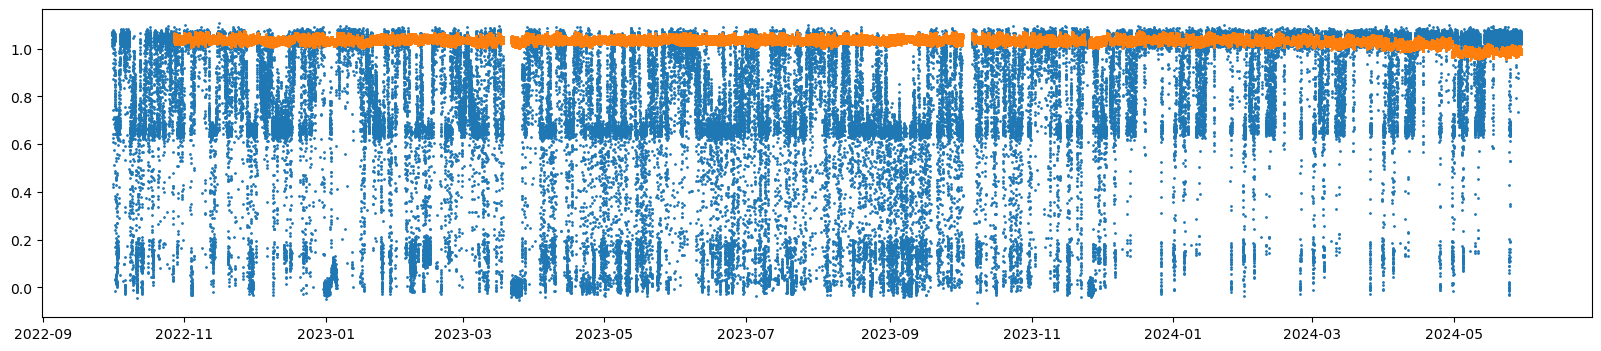

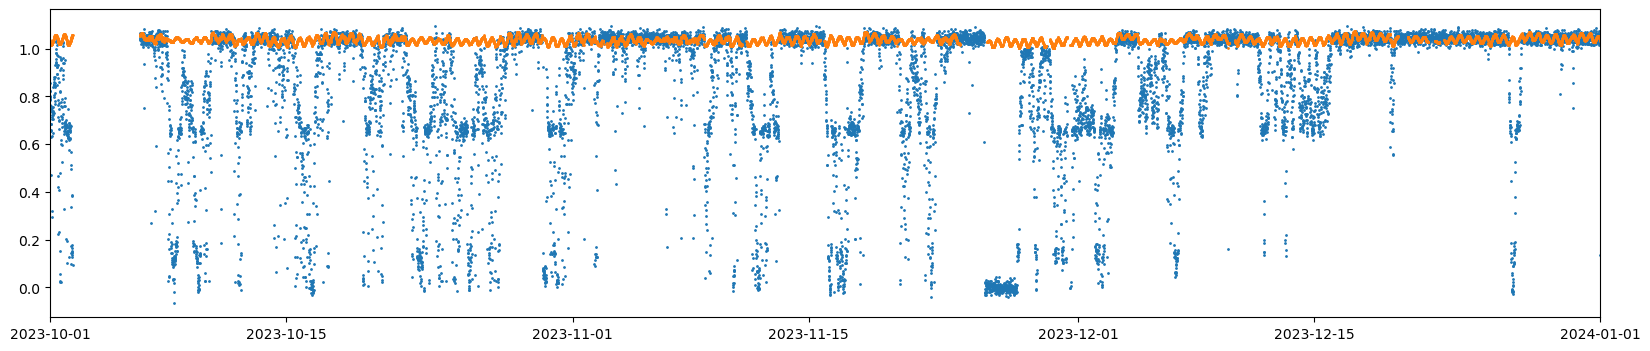

In [8]:
plt.figure(figsize=(20, 4))
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
#plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode_with_anomalies.index, physical_mode_with_anomalies, s=1)
plt.show()
plt.figure(figsize=(20, 4))
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
#plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode_with_anomalies.index, physical_mode_with_anomalies, s=1)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2024,1,1, tzinfo=datetime.timezone.utc))
plt.show()

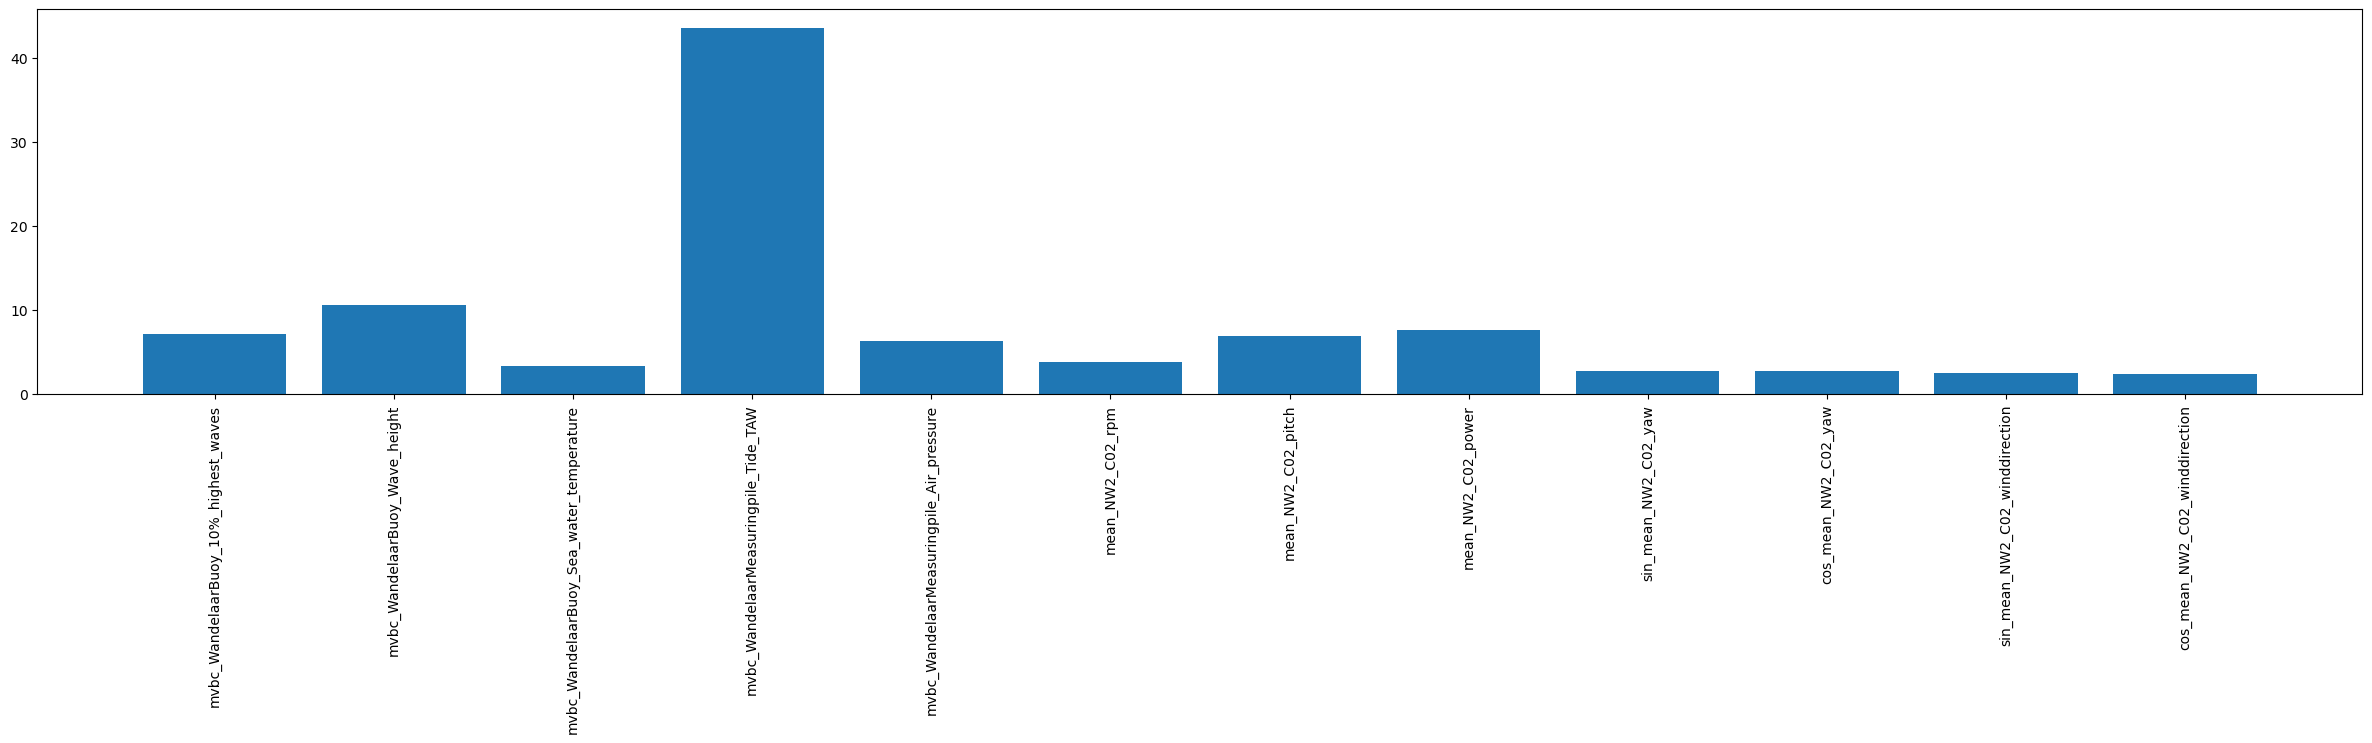

In [9]:
from catboost import CatBoostRegressor
from src.data.preprocessing import sin_cos_angle_inputs

X = sin_cos_angle_inputs(augmented_inputs.copy())
y = physical_mode_with_anomalies.copy()
common_indices_Xy = X.index.intersection(y.index)
X = X.loc[common_indices_Xy]
y = y.loc[common_indices_Xy]

# low_rpm = augmented_inputs[augmented_inputs[augmented_inputs.filter(regex='rpm').columns[0]]<10].loc[:start_anomaly]
# common_indices = X.dropna().index.intersection(low_rpm.index)

common_indices = X.dropna().index.intersection(ss2_selected.index)
common_indices = common_indices.intersection(y.index)
y_train = y.loc[common_indices]
X_train = X.loc[common_indices]
y_train = y_train.loc[common_indices]

regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()

In [10]:
import pandas as pd
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)

predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=100, ntree_end=500) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

uncertainty_lim = uncertainty_.loc[X_train.index].quantile(0.5)
prediction_lim = (y_train - predictions_df['prediction'].loc[X_train.dropna().index]).std()*30
prediction_lim = (y['freq'] - predictions_df['prediction']).std()*5

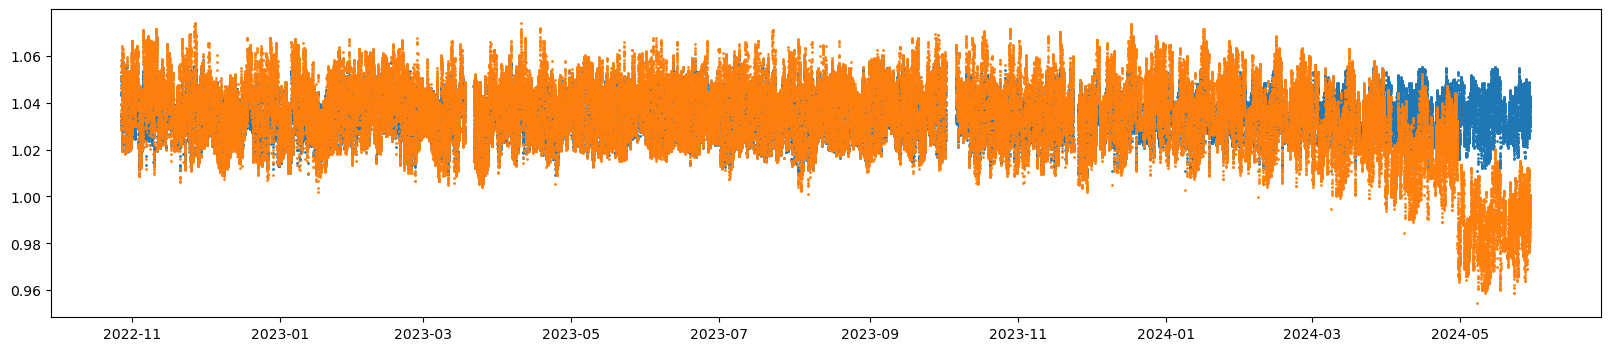

In [11]:
plt.figure(figsize=(20,4))
plt.scatter(predictions_df.index, predictions_df['prediction'], s=1)
plt.scatter(y.index, y, s=1)

In [12]:
harmonic_6p_input = pd.DataFrame({
    'freq':harmonic_6p},
    index=harmonic_6p.index
    )

differences = (harmonic_6p_input-physical_mode_with_anomalies).rename(columns={'freq':'diff'})
small_differences = differences[np.abs(differences['diff'])<0.2]

all_inputs = pd.concat([physical_mode_with_anomalies[~physical_mode_with_anomalies.index.isin(small_differences.index)], harmonic_6p_input], axis=0)
all_inputs.sort_index(inplace=True)
all_inputs_final = all_inputs

# Smart tracking
from src.smart_tracking.smart_tracking import *

smart_tracked = smart_tracking(
    all_inputs_final['freq'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )

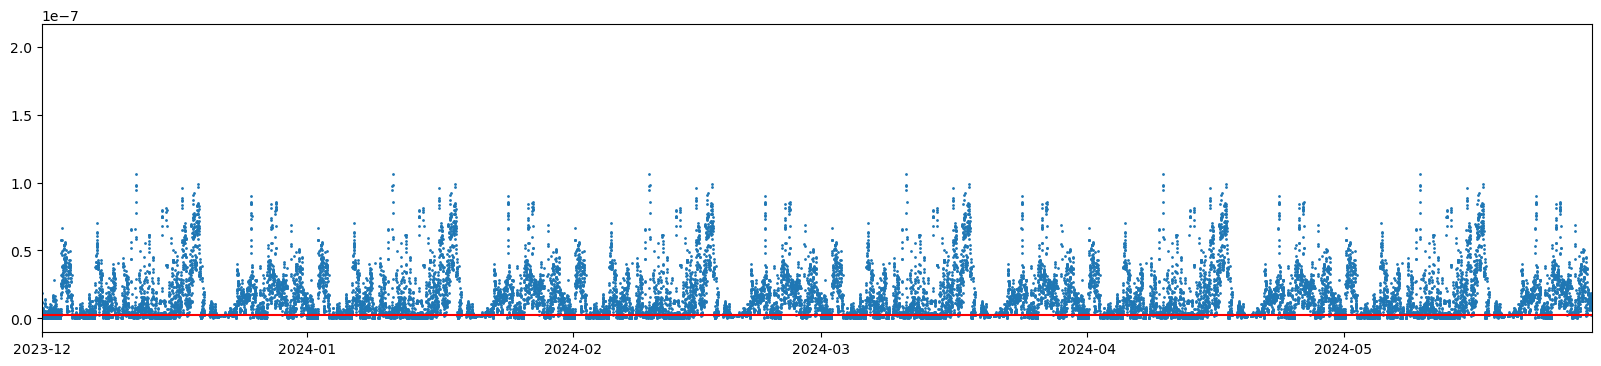

(19692.0, 19873.0)

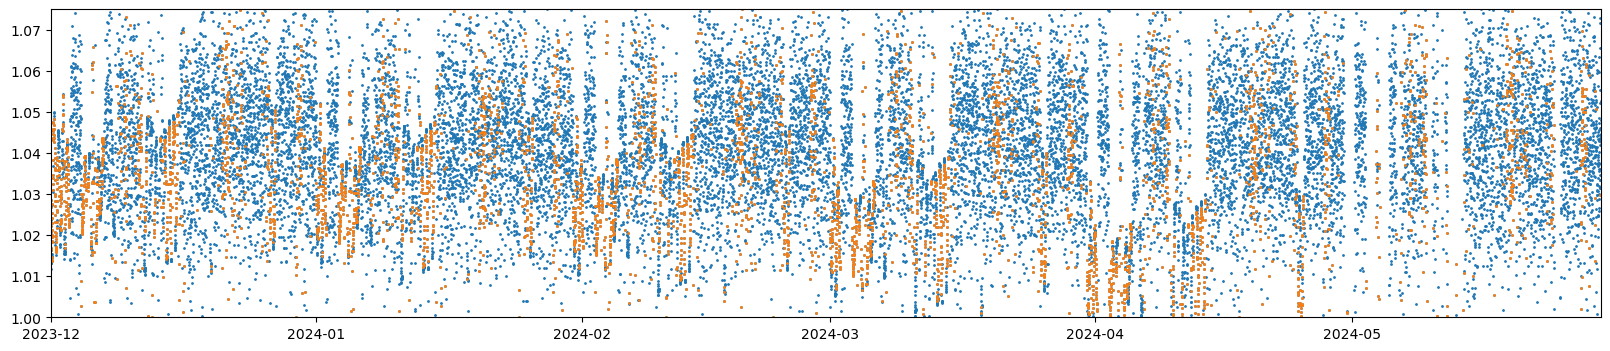

In [13]:
plt.figure(figsize=(20, 4))
plt.scatter(uncertainty_.index, uncertainty_, s=1)
#plt.scatter(uncertainty_moving_avg.index, uncertainty_moving_avg, s=1)
plt.hlines(uncertainty_lim, uncertainty_moving_avg.index[0], uncertainty_moving_avg.index[-1], color='r')
plt.xlim(datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc), all_inputs.index[-1])
plt.show()
plt.figure(figsize=(20, 4))
plt.scatter(all_inputs_final.index, all_inputs_final['freq'], s=1)
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, c='tab:orange')
#plt.fill_between(predictions_df.index, predictions_df['prediction']-prediction_lim, predictions_df['prediction']+prediction_lim, color='tab:orange', alpha=0.1)
plt.scatter(smart_tracked.index, smart_tracked['freq'], s=1)
#plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.ylim(1,1.075)
plt.xlim(datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc), all_inputs.index[-1])

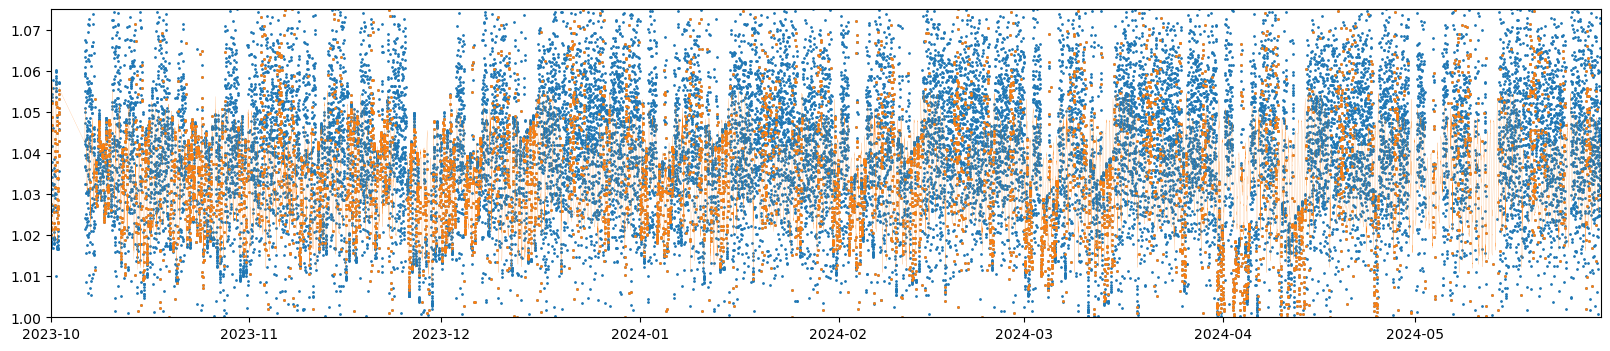

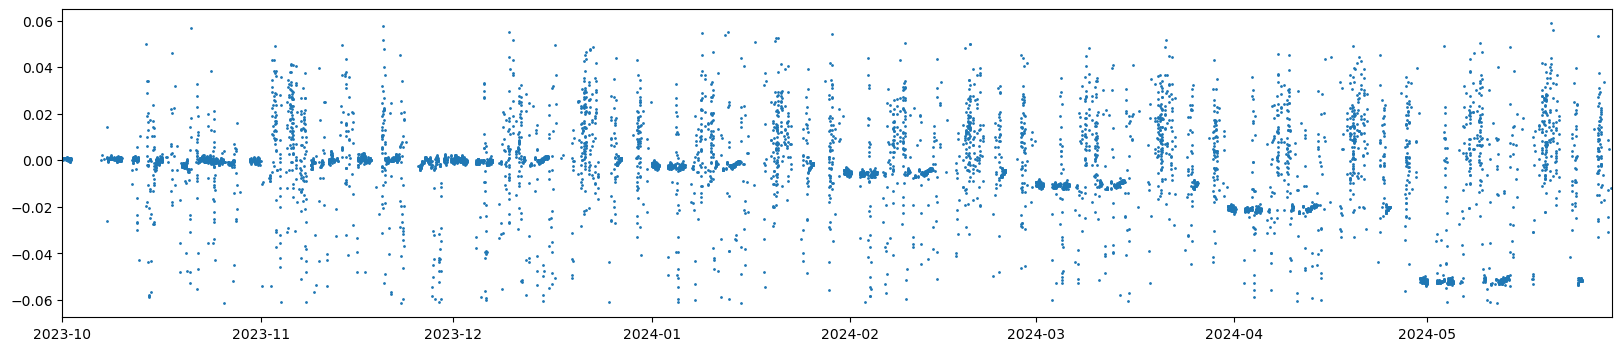

In [14]:
smart_tracked = smart_tracking(
    all_inputs_final['freq'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )
xlim_ = (datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), all_inputs_final.index[-1])

plt.figure(figsize=(20, 4))
plt.scatter(all_inputs.index, all_inputs['freq'], s=1)
plt.scatter(smart_tracked.index, smart_tracked['freq'], s=1)
plt.plot(predictions_df.index, predictions_df['prediction'], c='tab:orange', linewidth=0.1)
plt.ylim(0.95,1.12)
plt.xlim(xlim_)
plt.ylim(1,1.075)
plt.show()
plt.close()

residual = smart_tracked['freq'] - predictions_df['prediction']
residual_smart_tracked = residual.loc[smart_tracked.index]
plt.figure(figsize=(20, 4))
plt.scatter(residual_smart_tracked.index, residual_smart_tracked, s=1)
plt.xlim(xlim_)
plt.show()
plt.close()

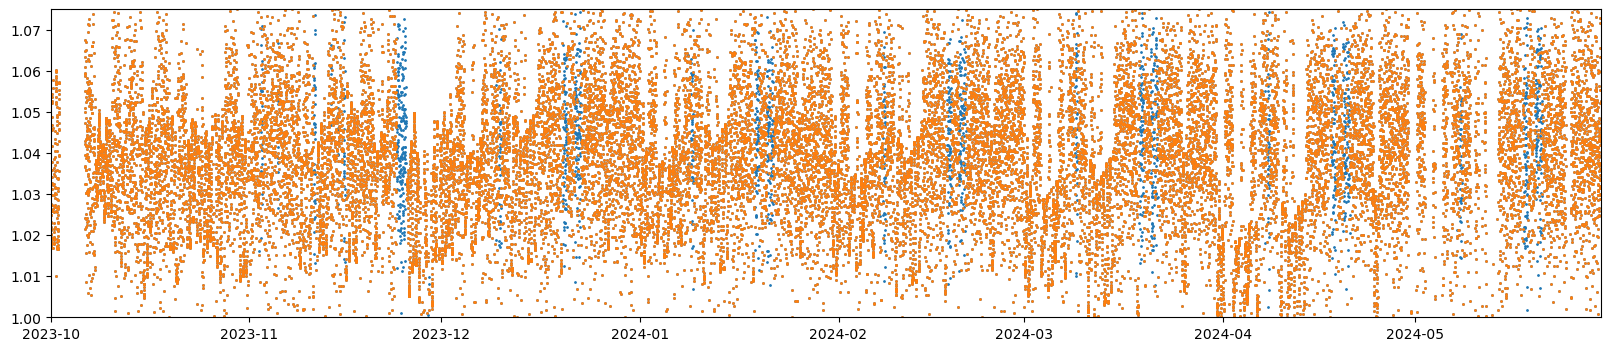

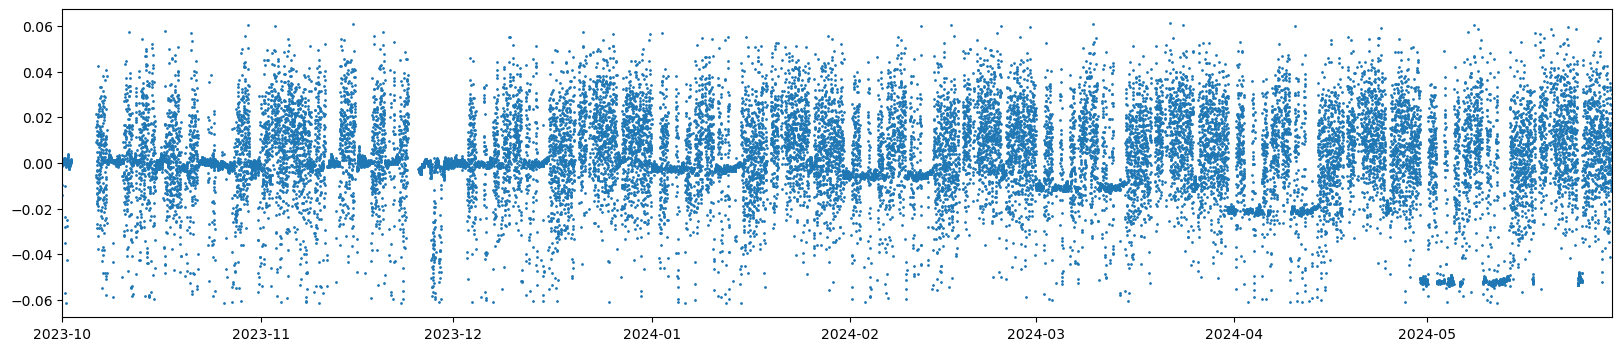

In [15]:
model_based_tracked = smart_tracking(
    all_inputs_final['freq'],
    predictions_df['prediction'],
    uncertainty_,
    10,
    prediction_lim
    )
xlim_ = (datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), all_inputs_final.index[-1])

residual = model_based_tracked['freq'] - predictions_df['prediction']
residual_model_based_tracked = residual.loc[model_based_tracked.index]
plt.figure(figsize=(20, 4))
plt.scatter(all_inputs.index, all_inputs['freq'], s=1)
plt.scatter(model_based_tracked.index, model_based_tracked['freq'], s=1)
plt.ylim(0.95,1.12)
plt.xlim(xlim_)
plt.ylim(1,1.075)
plt.show()
plt.figure(figsize=(20, 4))
plt.scatter(residual_model_based_tracked.index, residual_model_based_tracked, s=1)
plt.xlim(xlim_)

plt.show()

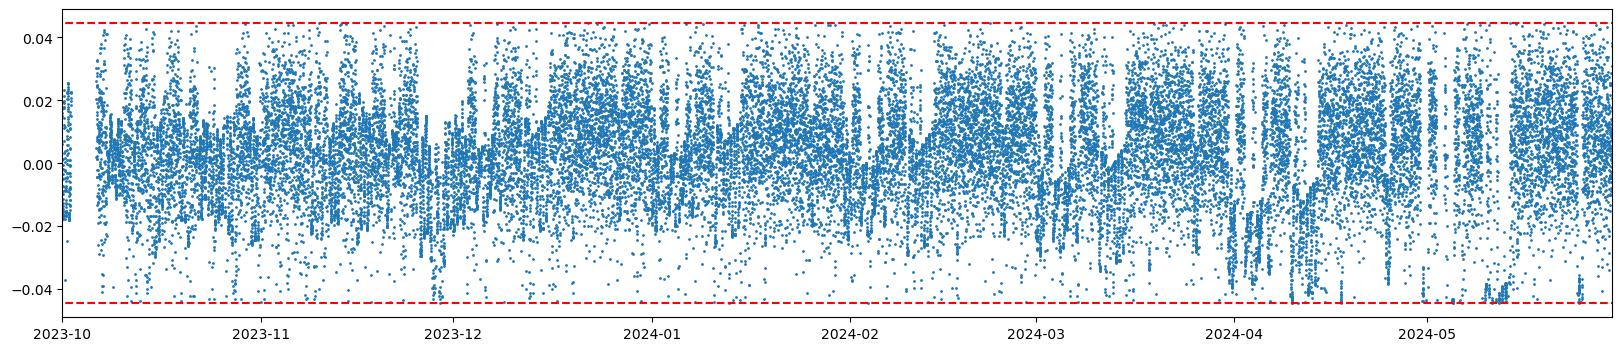

In [16]:
# reference-based tracking
ref_mean = ss2_selected['mean_frequency'].mean()
ref_std = ss2_selected['mean_frequency'].std()*3
ref_based_tracking = all_inputs_final[(all_inputs_final['freq']>ref_mean-ref_std) & (all_inputs_final['freq']<ref_mean+ref_std)]
residual_ref_based_tracked = ref_based_tracking - ref_mean

xlim_ = (datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), all_inputs_final.index[-1])

plt.figure(figsize=(20, 4))
plt.scatter(residual_ref_based_tracked.index,residual_ref_based_tracked['freq'],s=1)
plt.hlines(ref_std, all_inputs_final.index[0], all_inputs_final.index[-1], color='r', linestyle='--')
plt.hlines(-ref_std, all_inputs_final.index[0], all_inputs_final.index[-1], color='r', linestyle='--')
plt.xlim(xlim_)
plt.show()
plt.close()

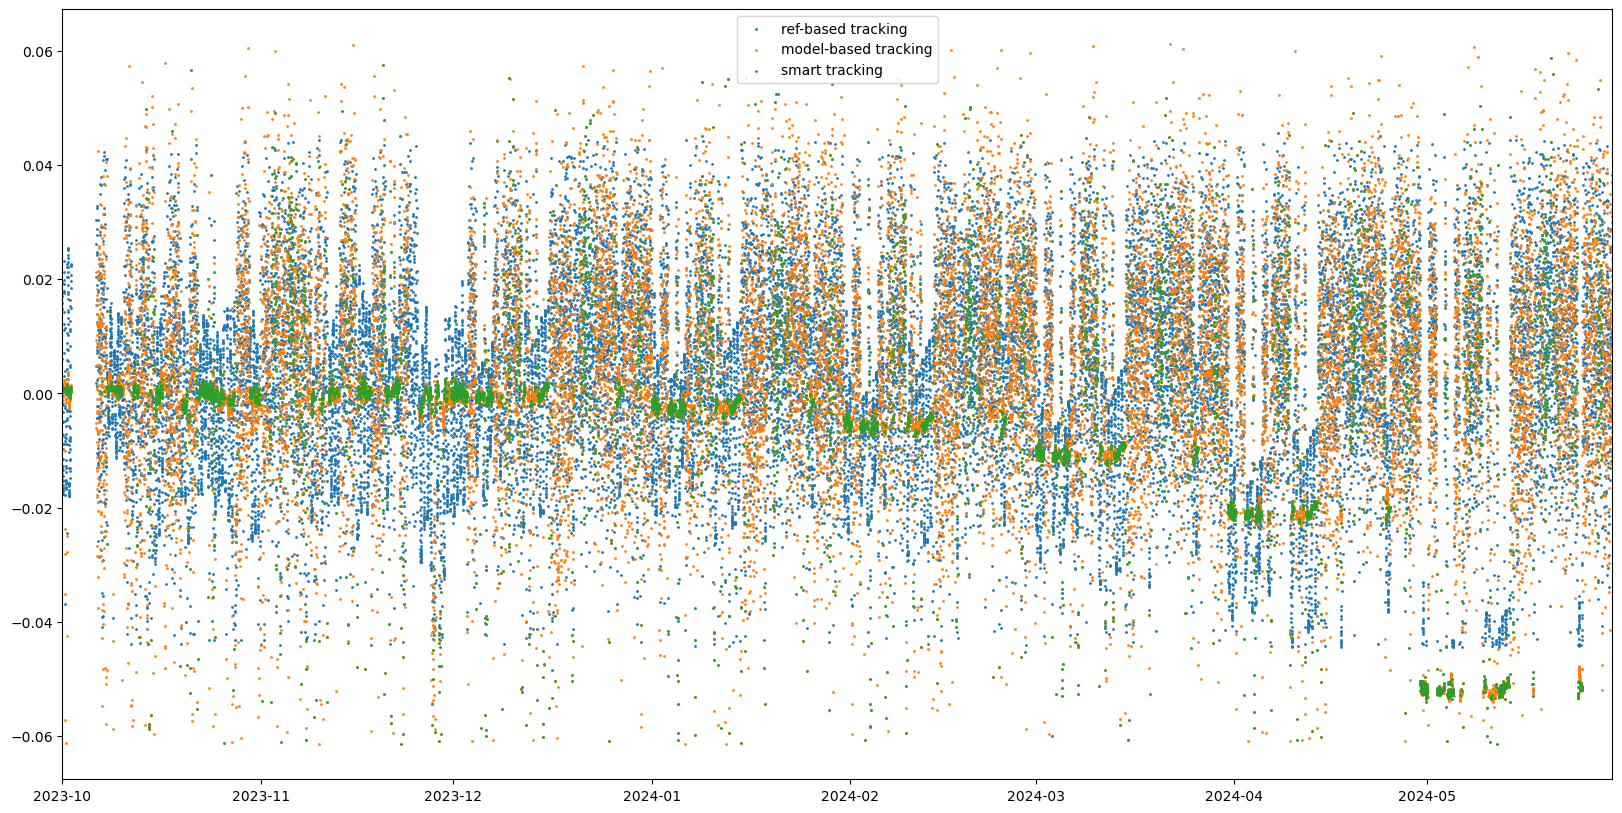

In [17]:
plt.figure(figsize=(20, 10))
plt.scatter(residual_ref_based_tracked.index,residual_ref_based_tracked,s=1, label='ref-based tracking')
plt.scatter(residual_model_based_tracked.index, residual_model_based_tracked, s=1, label='model-based tracking')
plt.scatter(residual_smart_tracked.index, residual_smart_tracked, s=1, label='smart tracking')
plt.legend()
plt.xlim(xlim_)
plt.show()
plt.close()

In [18]:
anomaly_timestamps

{0.2: Timestamp('2024-01-01 00:00:00+0000', tz='UTC'),
 0.5: Timestamp('2024-01-31 00:00:00+0000', tz='UTC'),
 1: Timestamp('2024-03-01 00:00:00+0000', tz='UTC'),
 2: Timestamp('2024-03-31 00:00:00+0000', tz='UTC'),
 5: Timestamp('2024-04-30 00:00:00+0000', tz='UTC')}

In [19]:
list(anomaly_timestamps.values())

[Timestamp('2024-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2024-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-01 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-31 00:00:00+0000', tz='UTC'),
 Timestamp('2024-04-30 00:00:00+0000', tz='UTC')]

C:\Users\Max\AppData\Local\Temp\ipykernel_8232\4154945347.py:43: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legend_.legendHandles:


0.38016528925619836
0.5041322314049587
0.628099173553719
0.7520661157024794
0.8760330578512396


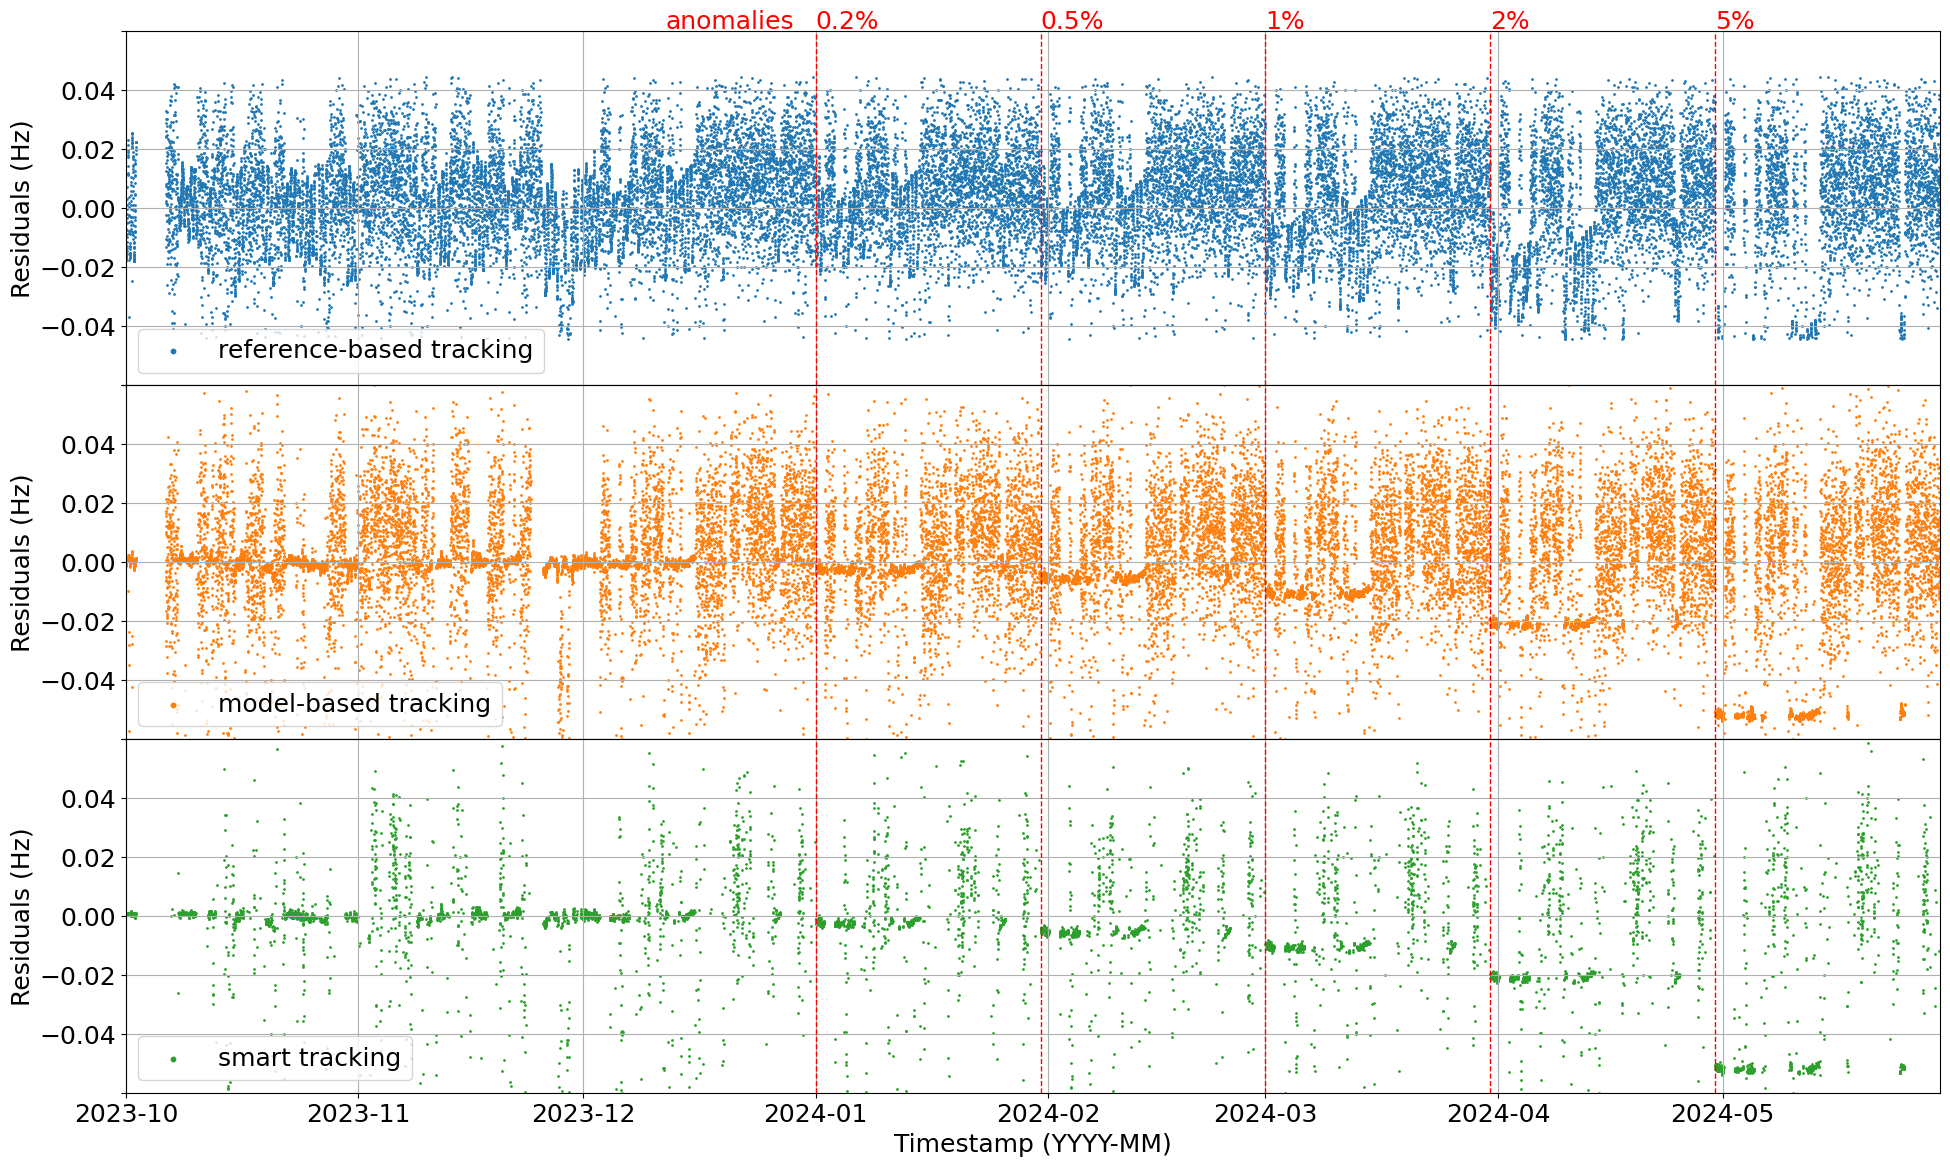

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Assuming 'xlim_' is already defined and contains the limits for the x-axis.
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 12))  # Creates a figure and 3 subplots
global_ylim = (-0.06, 0.06)
# Plot for ref-based tracking
axs[0].scatter(residual_ref_based_tracked.index, residual_ref_based_tracked, s=1, label='reference-based tracking')
axs[0].legend(loc='lower left')
axs[0].set_xlim(xlim_)
axs[0].set_ylim(global_ylim)
axs[0].set_ylabel('Residuals (Hz)')
axs[0].grid()

# Plot for model-based tracking
axs[1].scatter(residual_model_based_tracked.index, residual_model_based_tracked, s=1, label='model-based tracking', color='tab:orange')
axs[1].legend(loc='lower left')
axs[1].set_xlim(xlim_)
axs[1].set_ylim(global_ylim)
axs[1].set_ylabel('Residuals (Hz)')
axs[1].grid()


# Plot for smart tracking
axs[2].scatter(residual_smart_tracked.index, residual_smart_tracked, s=1, label='smart tracking', color='tab:green')
axs[2].legend(loc='lower left')
axs[2].set_xlim(xlim_)
axs[2].set_ylim(global_ylim)
axs[2].set_ylabel('Residuals (Hz)')
axs[2].grid()



# Only the bottom subplot gets x-axis labels
axs[2].set_xlabel('Timestamp (YYYY-MM)')


# Adjust the legend marker size
legend_size = 10  # You can adjust this size to your preference
for legend in axs:
    for handle in legend.legend_.legendHandles:
        handle.set_sizes([legend_size])
# Add vertical lines and annotations at the top of the figure
for key, timestamp in anomaly_timestamps.items():
    norm_position = (mdates.date2num(timestamp) - axs[-1].get_xlim()[0]) / (axs[-1].get_xlim()[-1] - axs[-1].get_xlim()[0])
    print(norm_position)
    for ax in axs:
        ax.axvline(x=timestamp, color='red', linestyle='--', lw=1)  # Draw the vertical line within each subplot
    axs[0].text(timestamp, 0.061, str(key)+'%', color='red')
axs[0].text(list(anomaly_timestamps.values())[0] - datetime.timedelta(days=20), 0.061, 'anomalies', color='red')

for ax in axs:
    yticks = ax.yaxis.get_major_ticks()
    if yticks:
        yticks[-1].label1.set_visible(False)
        yticks[0].label1.set_visible(False)

# Adjust the layout so that there are no overlaps
plt.tight_layout()
fig.subplots_adjust(hspace=-0.0)  # You can change this value to suit your needs

plt.show()

In [21]:
(len(anomaly_timestamps.keys())+1)/2 % 2

1.0

1
2
3
4


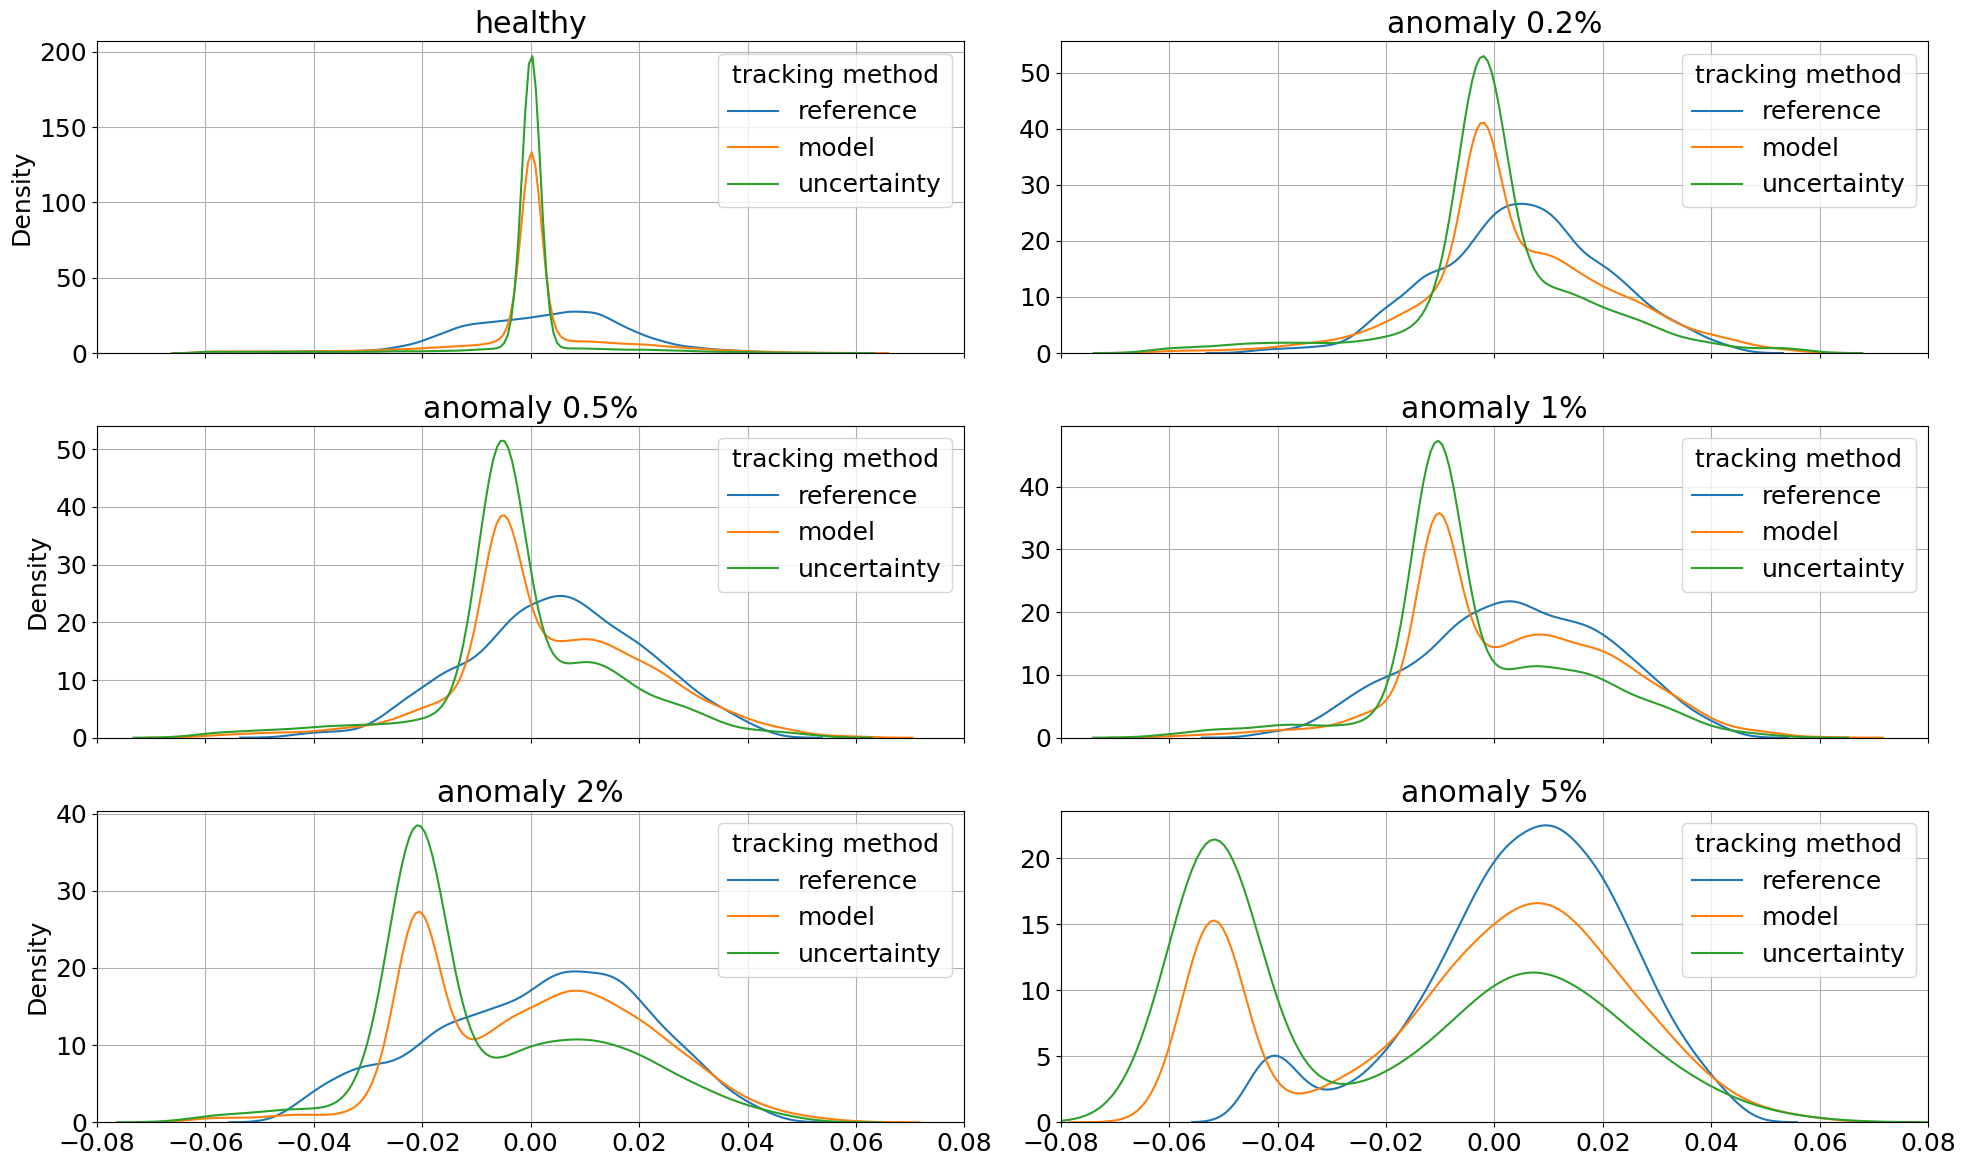

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the total number of plots needed
num_rows = (len(anomaly_timestamps.keys())+2) // 2  # Add one to handle odd numbers of months

# Set up the figure for subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 4 * num_rows))  # Adjust the height as needed

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Set global x and y limits if necessary
global_xlim = (-0.08, 0.08)  # Example limits, adjust as needed
global_ylim = (0, 200)     # Example limits, adjust as needed

# Iterate over each year and month as before
plot_count = 0
for i in range(len(anomaly_timestamps.keys())+1):
    if i == 0:
        title = 'healthy'
        indices_ref = residual_ref_based_tracked.index[residual_ref_based_tracked.index < list(anomaly_timestamps.values())[i] - datetime.timedelta(days=30)]
        indices_model = residual_model_based_tracked.index[residual_model_based_tracked.index < list(anomaly_timestamps.values())[i] - datetime.timedelta(days=30)]
        indices_smart = residual_smart_tracked.index[residual_smart_tracked.index < list(anomaly_timestamps.values())[i] - datetime.timedelta(days=30)]
    
    elif i >= len(anomaly_timestamps.keys()):
        title = 'anomaly ' + str(list(anomaly_timestamps.keys())[i-1]) + '%'
        indices_ref = residual_ref_based_tracked.index[residual_ref_based_tracked.index > list(anomaly_timestamps.values())[i-1]]
        indices_model = residual_model_based_tracked.index[residual_model_based_tracked.index > list(anomaly_timestamps.values())[i-1]]
        indices_smart = residual_smart_tracked.index[residual_smart_tracked.index > list(anomaly_timestamps.values())[i-1]]

    else:
        print(i)
        title = 'anomaly ' + str(list(anomaly_timestamps.keys())[i-1]) + '%'
        indices_ref = residual_ref_based_tracked.index[(residual_ref_based_tracked.index > list(anomaly_timestamps.values())[i-1]) & (residual_ref_based_tracked.index < list(anomaly_timestamps.values())[i])]
        indices_model = residual_model_based_tracked.index[(residual_model_based_tracked.index > list(anomaly_timestamps.values())[i-1]) & (residual_model_based_tracked.index < list(anomaly_timestamps.values())[i])]
        indices_smart = residual_smart_tracked.index[(residual_smart_tracked.index > list(anomaly_timestamps.values())[i-1]) & (residual_smart_tracked.index < list(anomaly_timestamps.values())[i])]

    ax = axs[plot_count]
    sns.kdeplot(residual_ref_based_tracked.loc[indices_ref], ax=ax, label='reference', color='tab:blue')
    sns.kdeplot(residual_model_based_tracked.loc[indices_model], ax=ax, label='model', color='tab:orange')
    sns.kdeplot(residual_smart_tracked.loc[indices_smart], ax=ax, label='uncertainty', color='tab:green')
    ax.set_title(title)
    ax.legend(loc= 'upper right', title='tracking method')
    ax.grid()
    # Set the axis limits to the global limits
    ax.set_xlim(global_xlim)
    #ax.set_ylim(global_ylim)
    
    # Remove y-labels for the second column
    if plot_count % 2 == 1:
        ax.set_ylabel('')

    # Remove x-labels for all but the last row
    if plot_count < len(axs) - 2:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    plot_count += 1

# If the number of months is odd, hide the last subplot
if (len(anomaly_timestamps.keys())+1) % 2 != 0:
    axs[-1].set_visible(False)

plt.tight_layout()
plt.show()


In [23]:
anomaly_timestamps

{0.2: Timestamp('2024-01-01 00:00:00+0000', tz='UTC'),
 0.5: Timestamp('2024-01-31 00:00:00+0000', tz='UTC'),
 1: Timestamp('2024-03-01 00:00:00+0000', tz='UTC'),
 2: Timestamp('2024-03-31 00:00:00+0000', tz='UTC'),
 5: Timestamp('2024-04-30 00:00:00+0000', tz='UTC')}

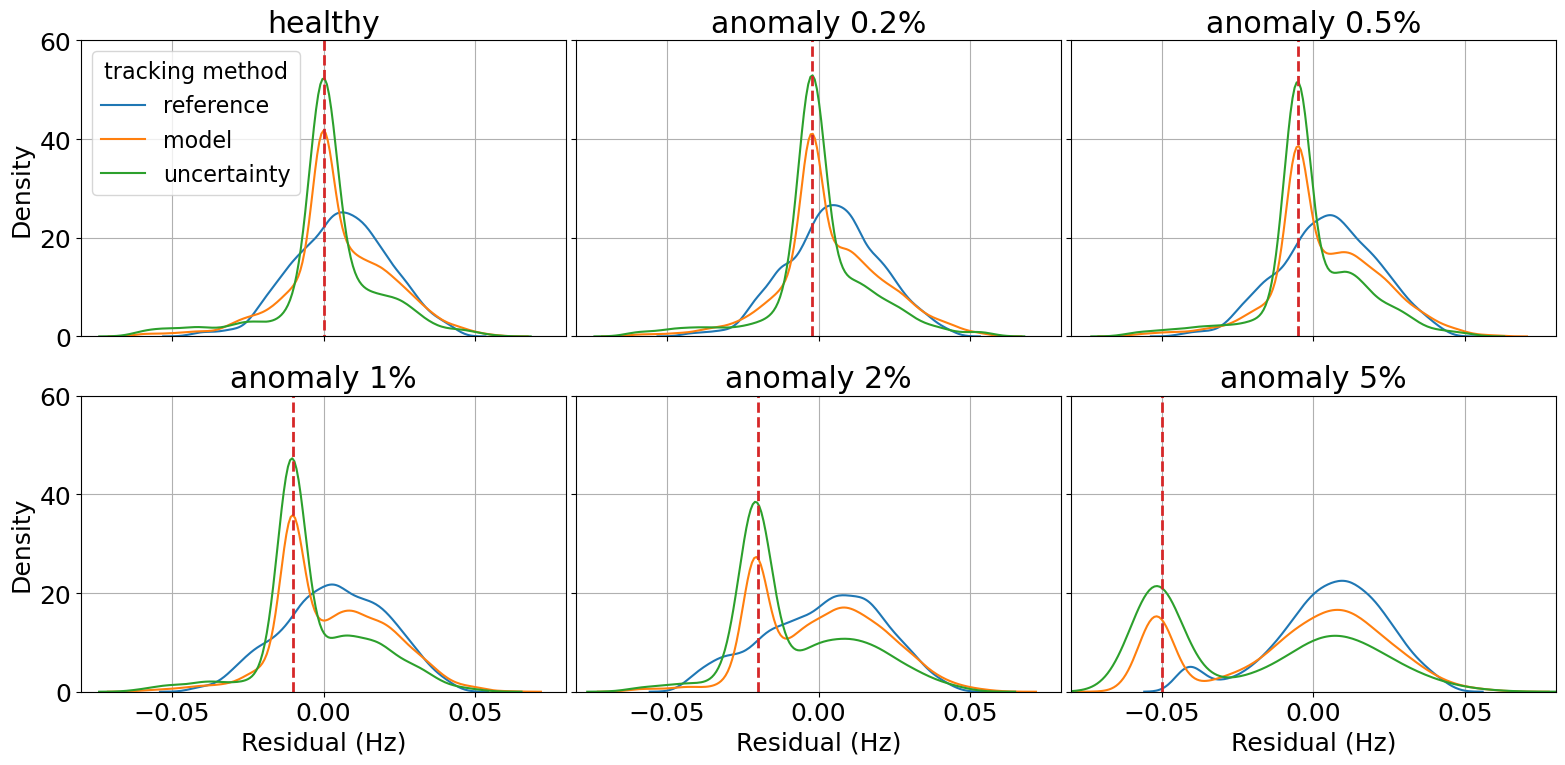

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the total number of plots needed
num_rows = (len(anomaly_timestamps.keys())+3) // 3  # Add one to handle odd numbers of months

# Set up the figure for subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(16, 4 * num_rows))  # Adjust the height as needed

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Set global x and y limits if necessary
global_xlim = (-0.08, 0.08)  # Example limits, adjust as needed
global_ylim = (0, 60)     # Example limits, adjust as needed

# Iterate over each year and month as before
plot_count = 0
for i in range(len(anomaly_timestamps.keys())+1):
    if i == 0:
        title = 'healthy'
        indices_ref = residual_ref_based_tracked.index[
            (residual_ref_based_tracked.index < list(anomaly_timestamps.values())[i]) & (residual_ref_based_tracked.index > list(anomaly_timestamps.values())[i] - datetime.timedelta(days=30))]
        indices_model = residual_model_based_tracked.index[
            (residual_model_based_tracked.index < list(anomaly_timestamps.values())[i]) & (residual_model_based_tracked.index > list(anomaly_timestamps.values())[i] - datetime.timedelta(days=30))]
        indices_smart = residual_smart_tracked.index[
            (residual_smart_tracked.index < list(anomaly_timestamps.values())[i]) & (residual_smart_tracked.index > list(anomaly_timestamps.values())[i] - datetime.timedelta(days=30))]

    elif i >= len(anomaly_timestamps.keys()):
        title = 'anomaly ' + str(list(anomaly_timestamps.keys())[i-1]) + '%'
        indices_ref = residual_ref_based_tracked.index[residual_ref_based_tracked.index > list(anomaly_timestamps.values())[i-1]]
        indices_model = residual_model_based_tracked.index[residual_model_based_tracked.index > list(anomaly_timestamps.values())[i-1]]
        indices_smart = residual_smart_tracked.index[residual_smart_tracked.index > list(anomaly_timestamps.values())[i-1]]

    else:
        title = 'anomaly ' + str(list(anomaly_timestamps.keys())[i-1]) + '%'
        indices_ref = residual_ref_based_tracked.index[(residual_ref_based_tracked.index > list(anomaly_timestamps.values())[i-1]) & (residual_ref_based_tracked.index < list(anomaly_timestamps.values())[i])]
        indices_model = residual_model_based_tracked.index[(residual_model_based_tracked.index > list(anomaly_timestamps.values())[i-1]) & (residual_model_based_tracked.index < list(anomaly_timestamps.values())[i])]
        indices_smart = residual_smart_tracked.index[(residual_smart_tracked.index > list(anomaly_timestamps.values())[i-1]) & (residual_smart_tracked.index < list(anomaly_timestamps.values())[i])]

    ax = axs[plot_count]
    sns.kdeplot(residual_ref_based_tracked.loc[indices_ref]['freq'], ax=ax, label='reference', color='tab:blue')
    sns.kdeplot(residual_model_based_tracked.loc[indices_model], ax=ax, label='model', color='tab:orange')
    sns.kdeplot(residual_smart_tracked.loc[indices_smart], ax=ax, label='uncertainty', color='tab:green')

    
    if i == 0:
        ax.legend(loc= 'upper left', title='tracking method', fontsize=16, title_fontsize=16)
        ax.vlines(global_ylim[0], global_ylim[1], 0, color='tab:red', linestyle='--', lw=2)
    elif i > 0:
        ax.vlines(x=-list(anomaly_timestamps.keys())[i-1]/100, ymin=global_ylim[0], ymax=global_ylim[1], color='tab:red', linestyle='--', lw=2)
    
    ax.set_title(title)
    ax.grid()
    ax.set_xlabel('Residual (Hz)')

    # Set the axis limits to the global limits
    ax.set_xlim(global_xlim)
    ax.set_ylim(global_ylim)
    
    # Remove x-labels for all but the last row
    if plot_count < len(axs) - 3:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
    # Remove y-labels for the second column
    if plot_count % 3 != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    
        
    xticks = ax.xaxis.get_major_ticks()
    if xticks:
        xticks[-1].label1.set_visible(False)
        xticks[0].label1.set_visible(False)
            
    plot_count += 1

# If the number of months is odd, hide the last subplot
if (len(anomaly_timestamps.keys())+1) % 2 != 0:
    axs[-1].set_visible(False)
plt.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.02)  # You can change this value to suit your needs

plt.show()


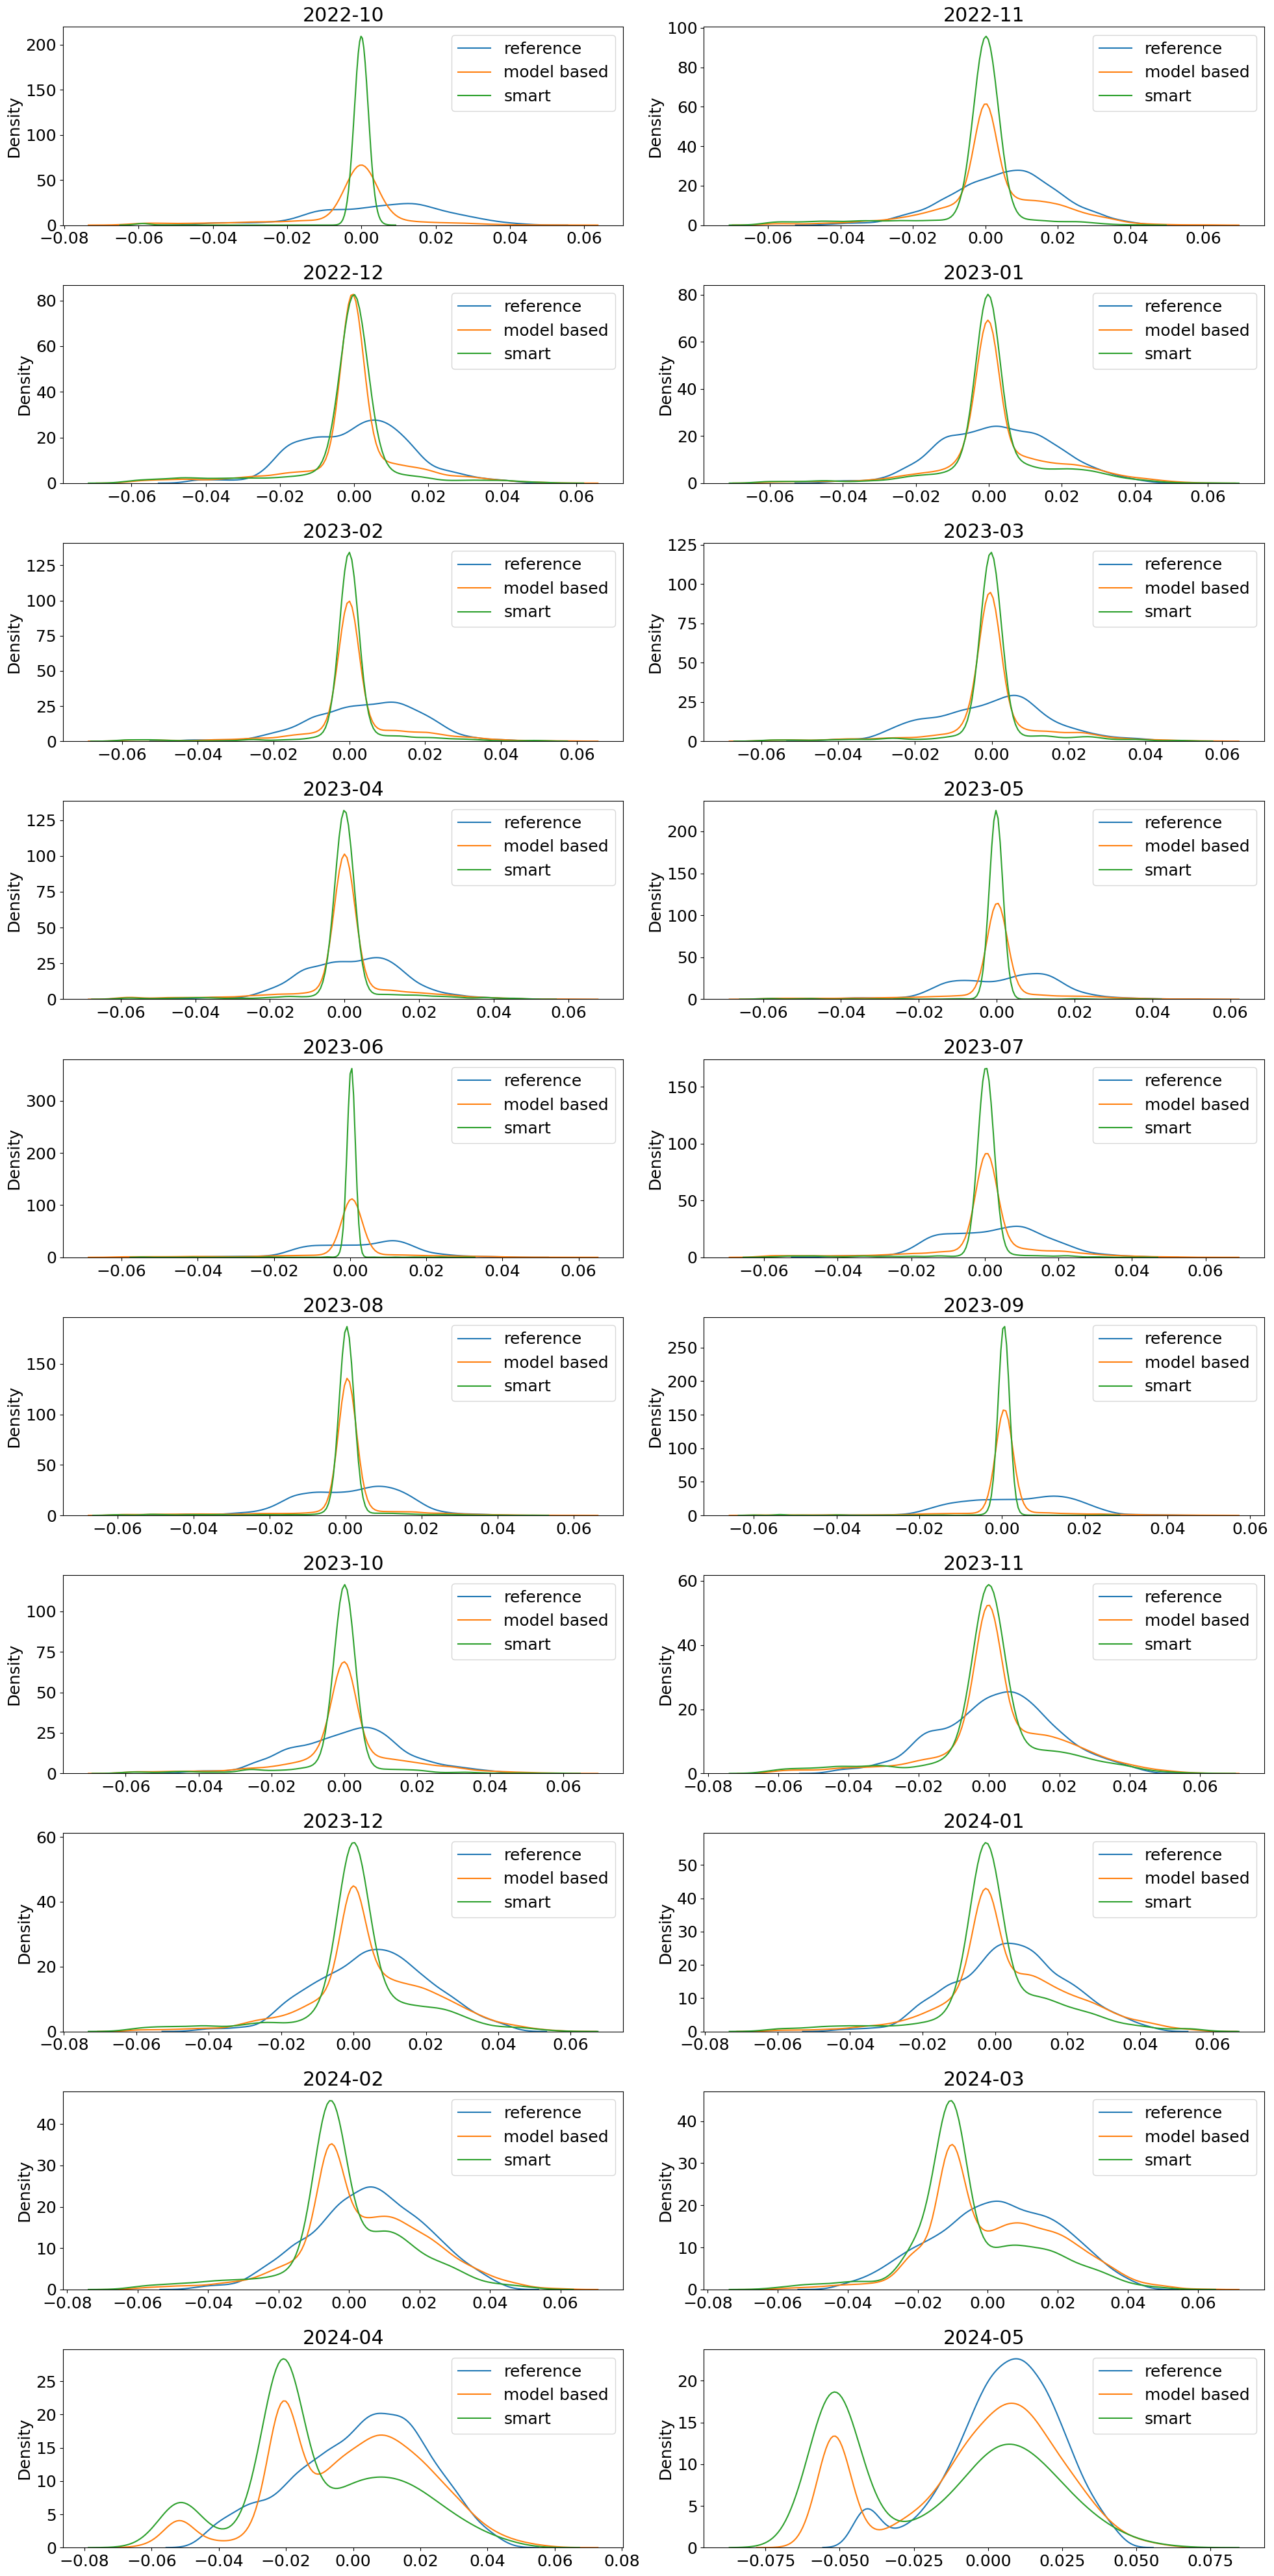

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the total number of plots needed
num_months = sum(len(residual_smart_tracked[residual_smart_tracked.index.year == year].index.month.unique()) for year in residual_smart_tracked.index.year.unique())
num_rows = (num_months + 1) // 2  # Add one to handle odd numbers of months

# Set up the figure for subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 4 * num_rows))  # Adjust the height as needed

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate over each year and month as before
plot_count = 0
for year in residual_smart_tracked.index.year.unique():
    indices_ref_based_tracking_year = residual_ref_based_tracked[residual_ref_based_tracked.index.year == year].index
    indices_of_this_year_smart = residual_smart_tracked[residual_smart_tracked.index.year == year].index
    indices_of_this_year_model = residual_model_based_tracked[residual_model_based_tracked.index.year == year].index

    residual_ref_tracking_year = residual_ref_based_tracked.loc[indices_ref_based_tracking_year]
    residual_model_based_tracked_year = residual_model_based_tracked.loc[indices_of_this_year_model]
    residual_smart_tracked_year = residual_smart_tracked.loc[indices_of_this_year_smart]
    
    for month in residual_smart_tracked_year.index.month.unique():
        ax = axs[plot_count]
        sns.kdeplot(residual_ref_tracking_year[residual_ref_tracking_year.index.month == month], ax=ax, label='reference', color='tab:blue')
        sns.kdeplot(residual_model_based_tracked_year[residual_model_based_tracked_year.index.month == month], ax=ax, label='model based', color='tab:orange')
        sns.kdeplot(residual_smart_tracked_year[residual_smart_tracked_year.index.month == month], ax=ax, label='smart', color='tab:green')
        ax.set_title(f'{year}-{month:02d}')
        ax.legend()
        
        plot_count += 1

# If the number of months is odd, hide the last subplot
if num_months % 2 != 0:
    axs[-1].set_visible(False)

plt.tight_layout()
plt.show()


2022 10


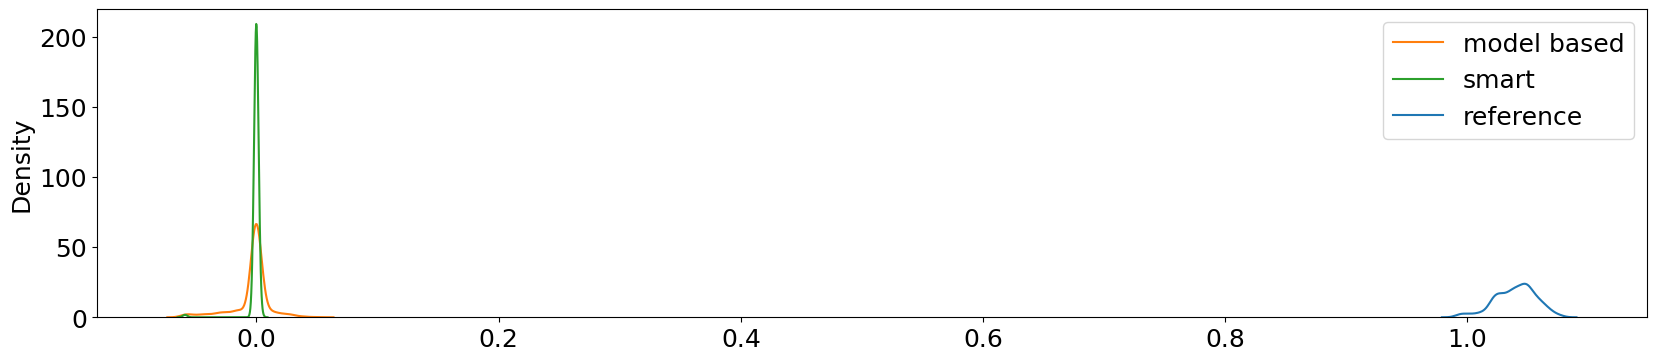

2022 11


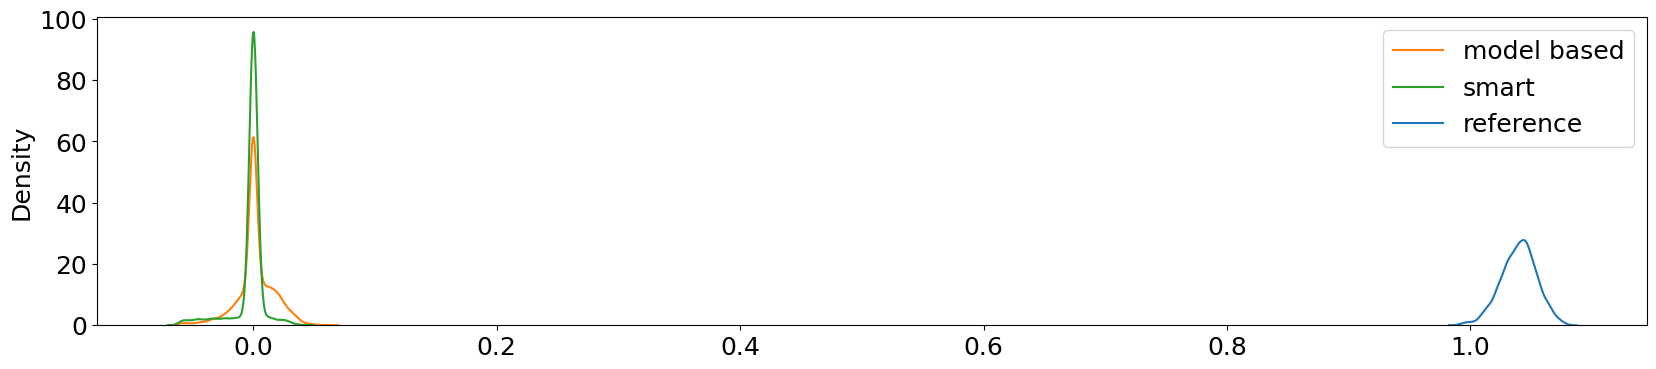

2022 12


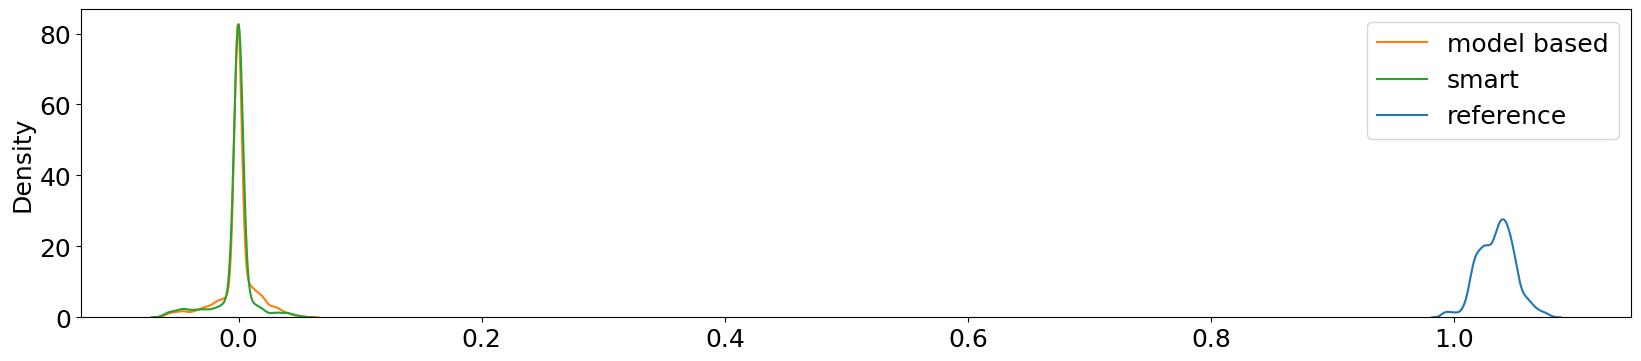

2023 1


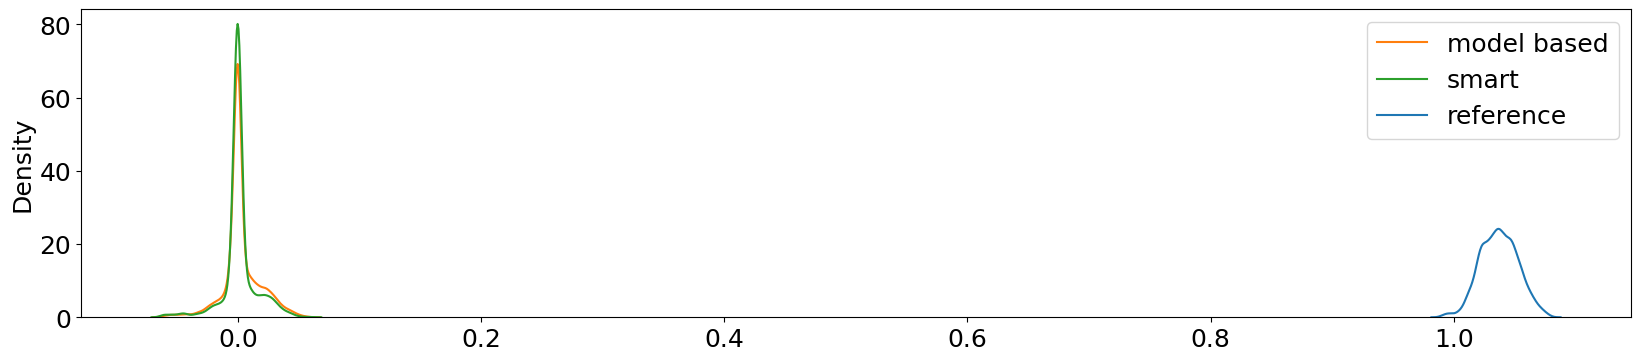

2023 2


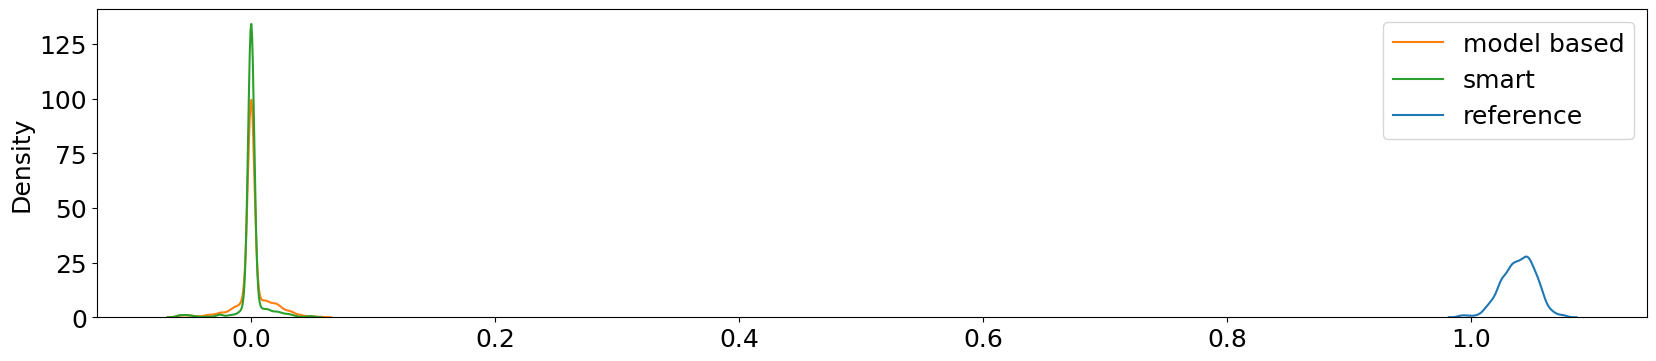

2023 3


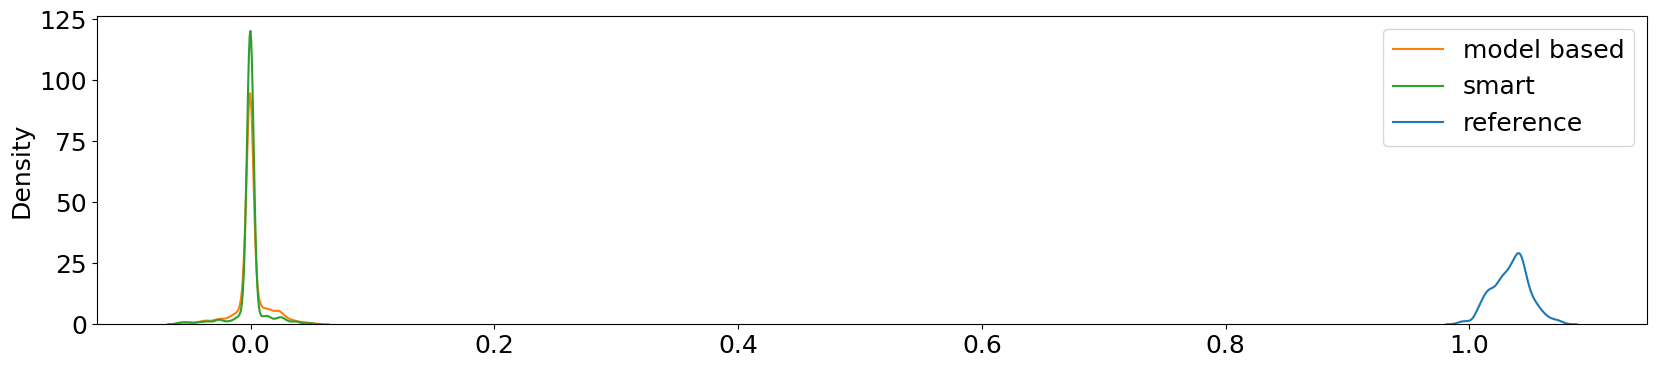

2023 4


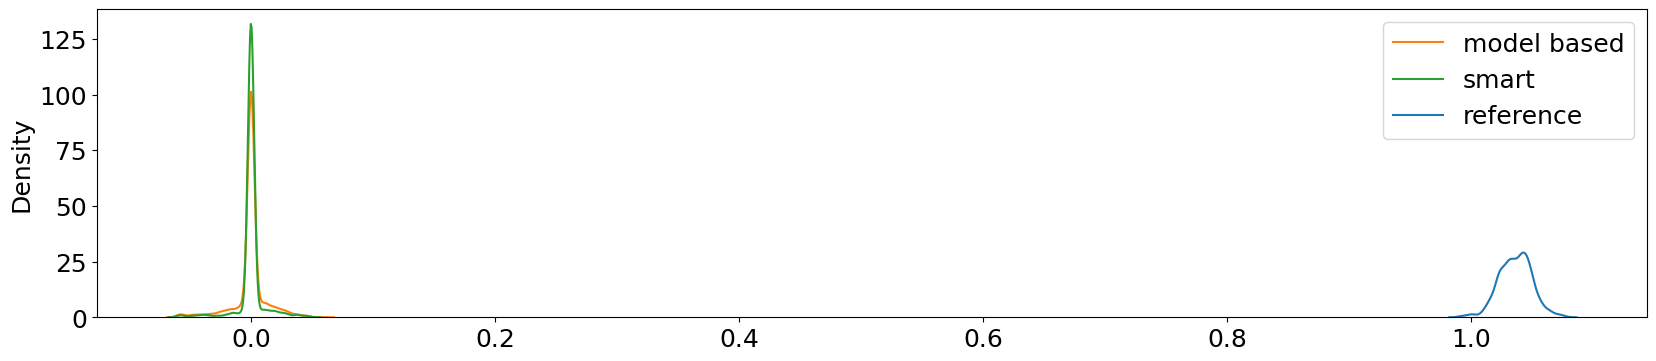

2023 5


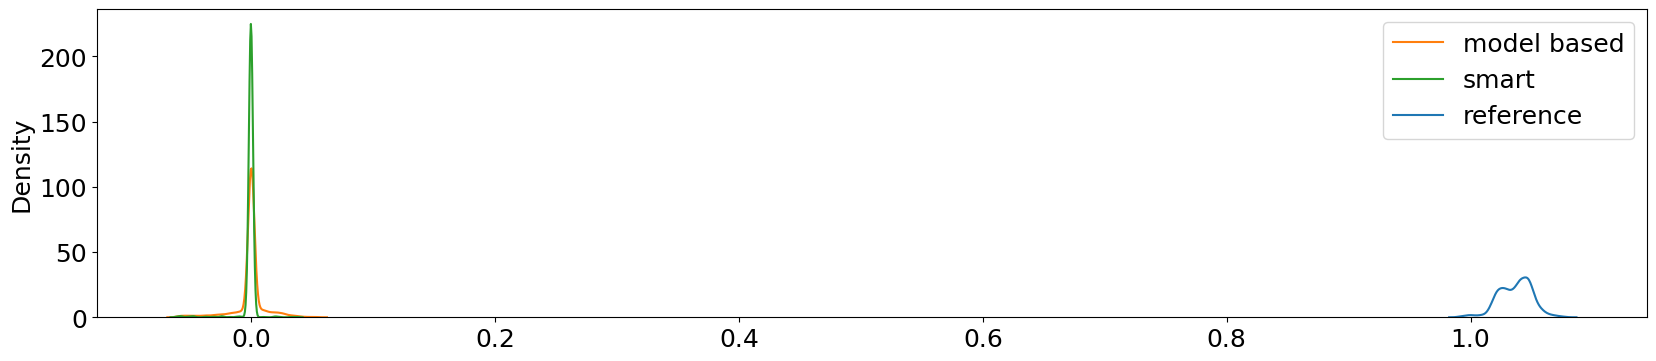

2023 6


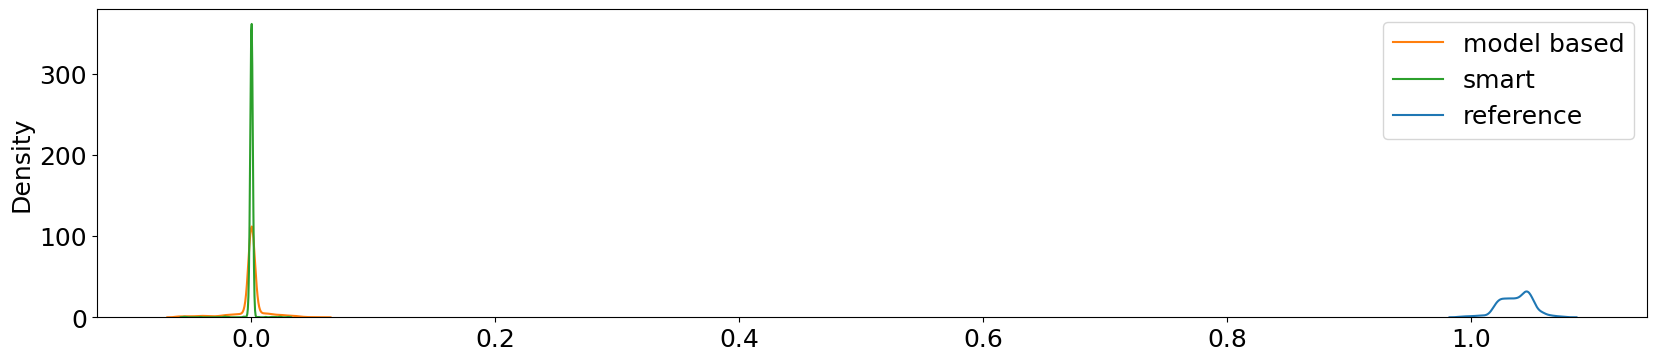

2023 7


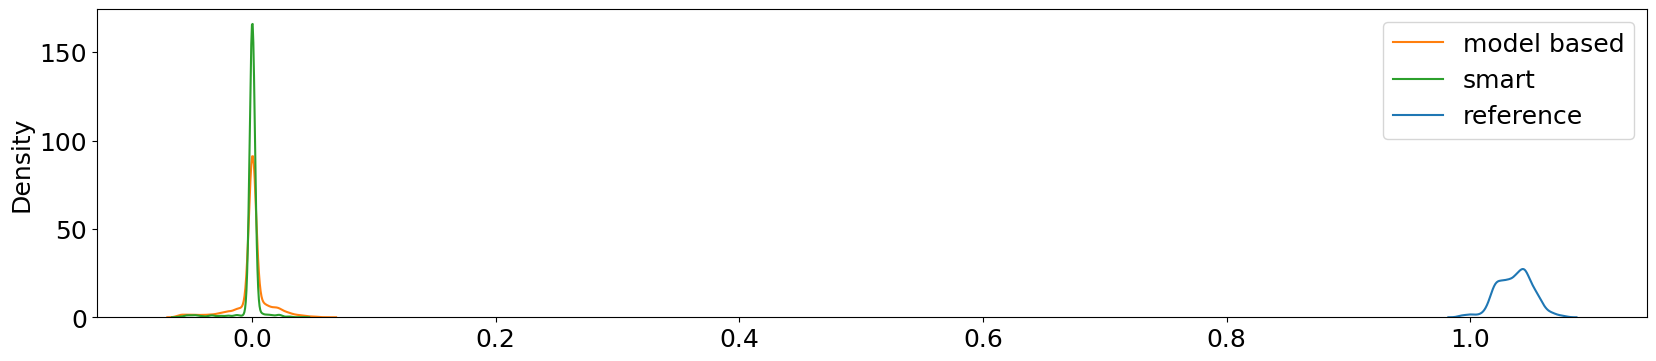

2023 8


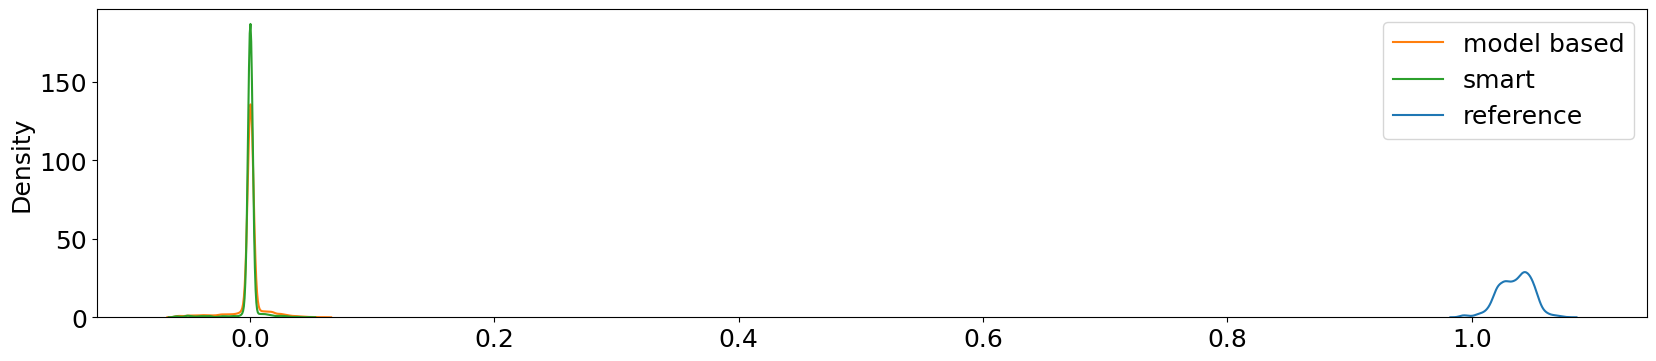

2023 9


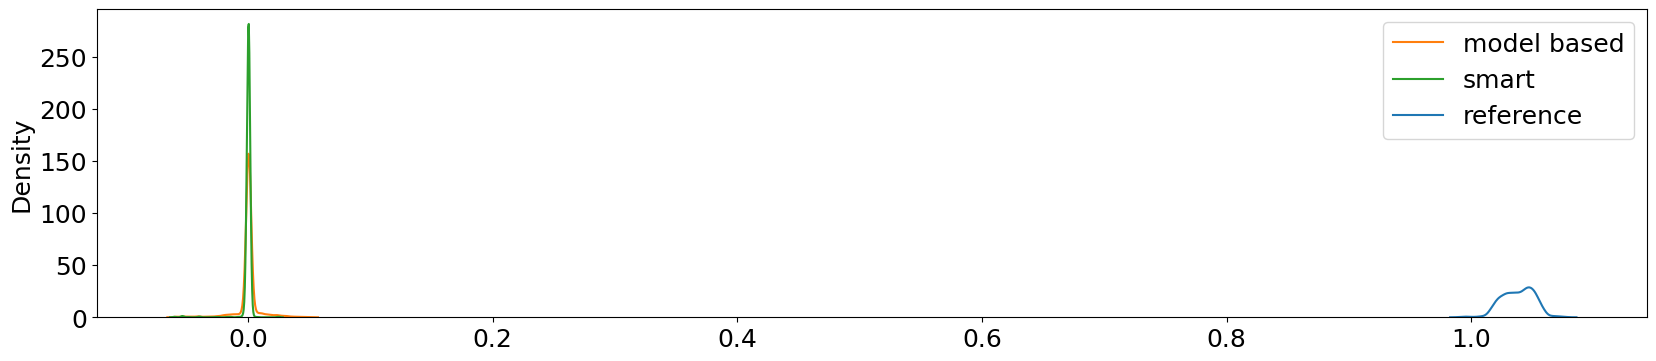

2023 10


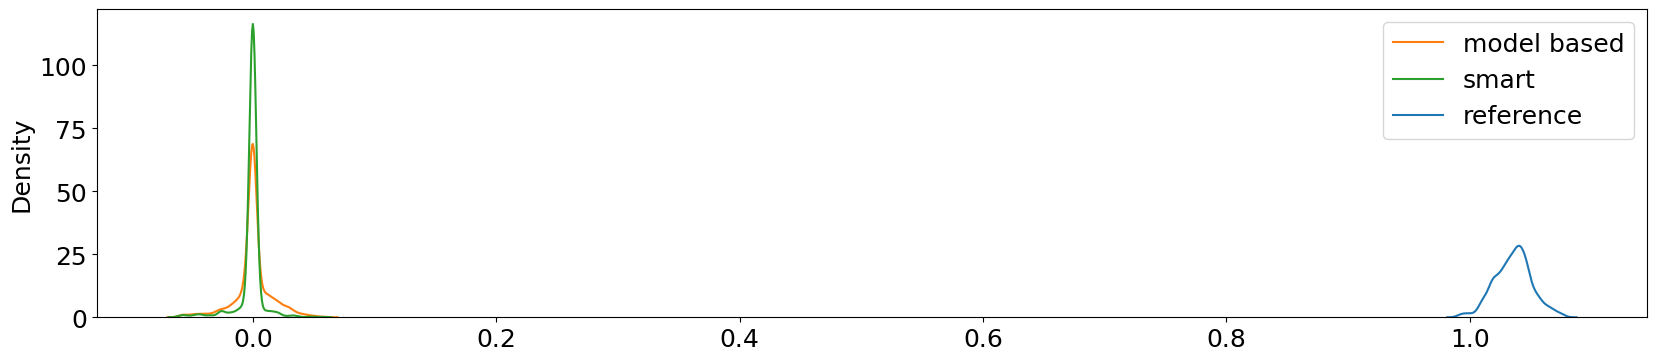

2023 11


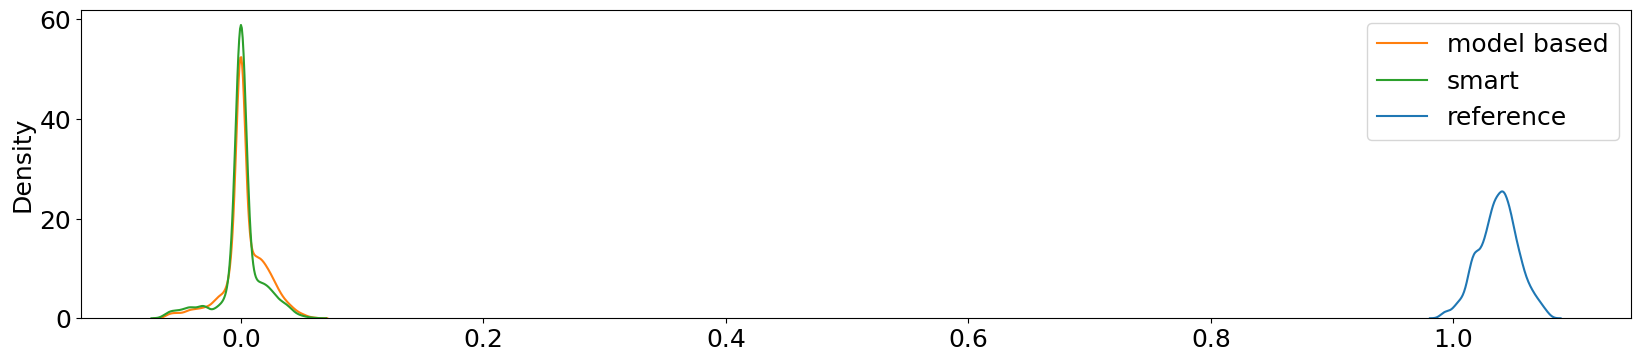

2023 12


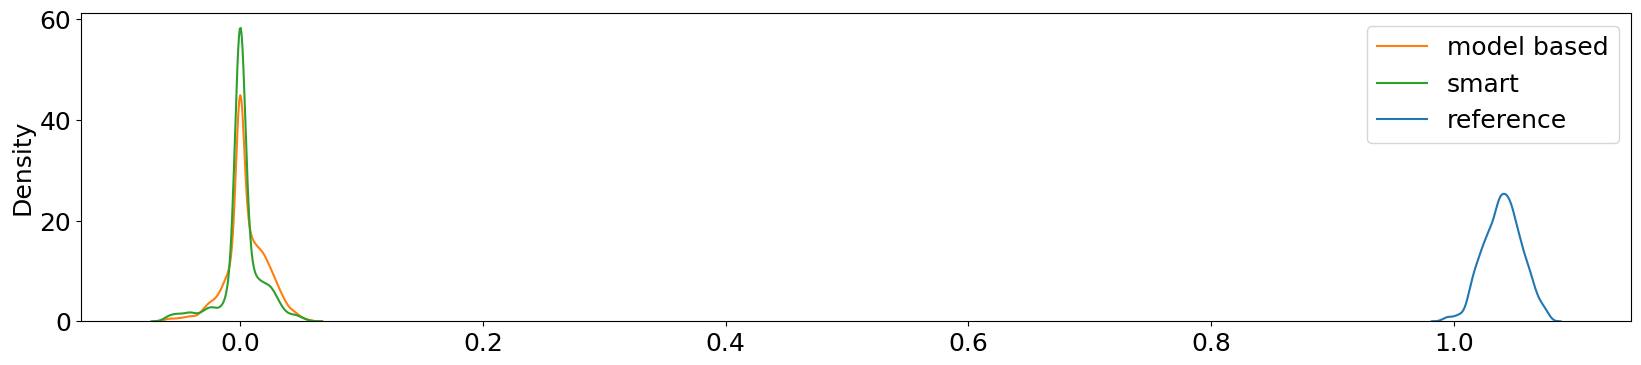

2024 1


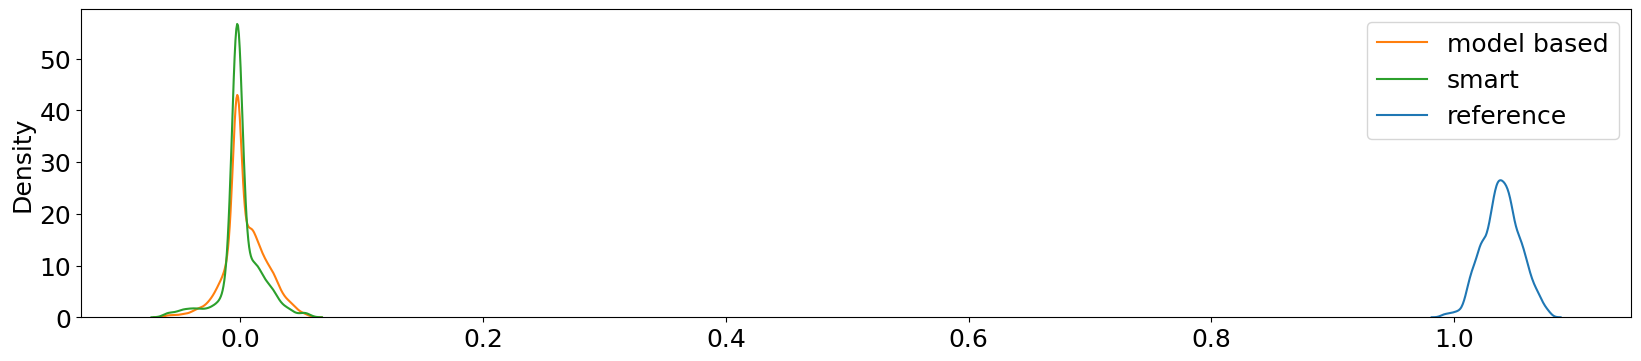

2024 2


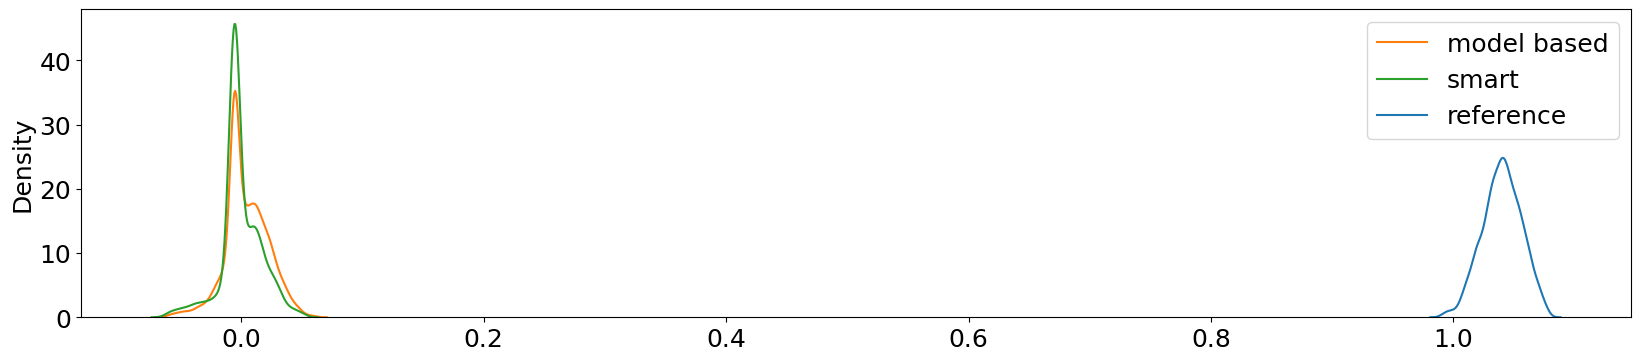

2024 3


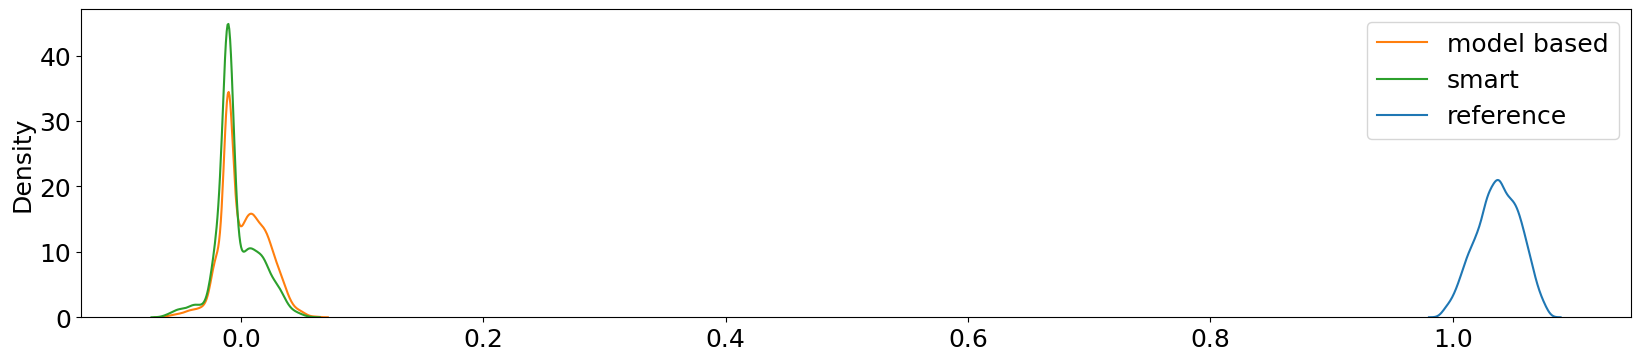

2024 4


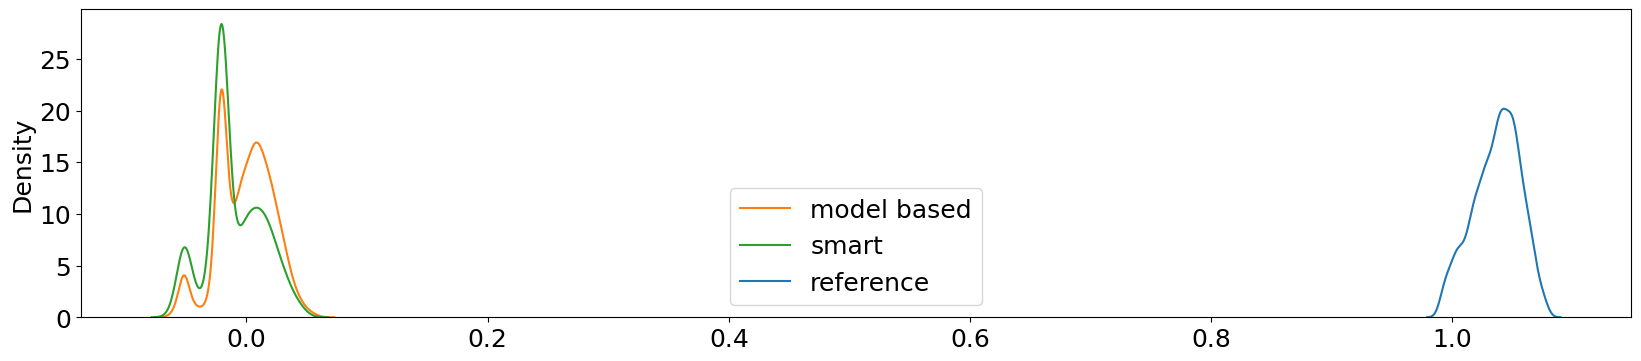

2024 5


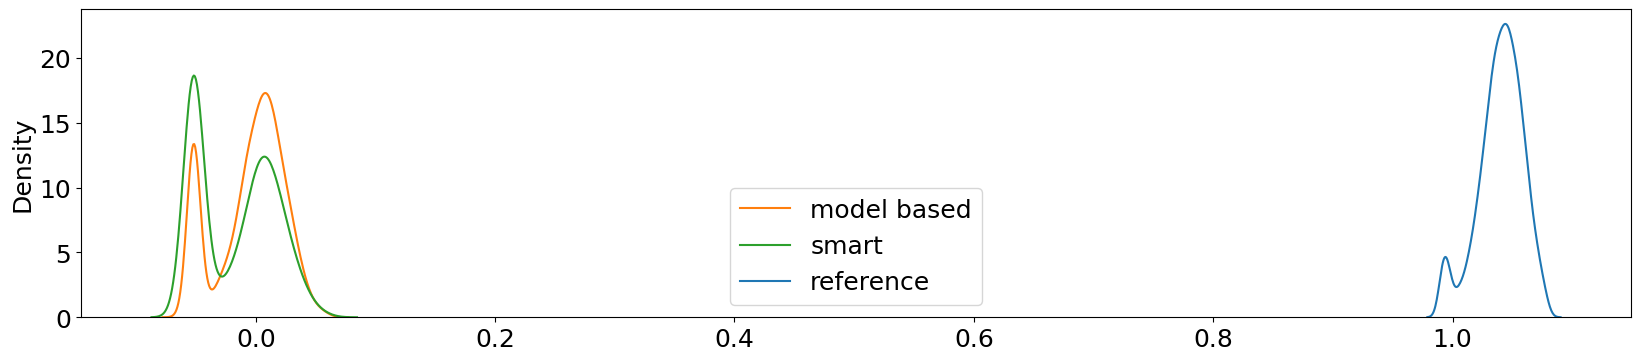

In [26]:
import seaborn as sns
for year in residual_smart_tracked.index.year.unique():
    indices_of_this_year_smart = residual_smart_tracked[residual_smart_tracked.index.year==year].index
    indices_of_this_year_model = residual_model_based_tracked[residual_model_based_tracked.index.year==year].index
    indices_ref_based_tracking_year = ref_based_tracking[ref_based_tracking.index.year==year].index
    residual_model_based_tracked_year = residual_model_based_tracked.loc[indices_of_this_year_model]
    residual_smart_tracked_year = residual_smart_tracked.loc[indices_of_this_year_smart]
    residual_ref_tracking_year = ref_based_tracking.loc[indices_ref_based_tracking_year]
    for month in residual_smart_tracked_year.index.month.unique():
        plt.figure(figsize=(20, 4))
        print(year, month)
        sns.kdeplot(residual_model_based_tracked_year.loc[residual_model_based_tracked_year.index.month==month], label='model based', color='tab:orange')
        sns.kdeplot(residual_smart_tracked_year.loc[residual_smart_tracked_year.index.month==month], label='smart', color='tab:green')
        sns.kdeplot(residual_ref_tracking_year.loc[residual_ref_tracking_year.index.month==month], label='reference', color='tab:blue')
        plt.legend()
        plt.show()